# Paquetes

In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import Alphas101 as Alphas

import matplotlib as plt
from math import sqrt
from yellowbrick.cluster import KElbowVisualizer
from statistics import stdev
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical
from sklearn.metrics import adjusted_rand_score
import random

'''Algos'''
import tslearn
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets
import operator
import calendar
import itertools as it

import time

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


# Funciones Auxiliares

### Kshape

In [25]:
def strategy_kshape(df, K = 4):
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)[:,:,0]
    ks = KShape(n_clusters=K, max_iter=100, n_init=100, verbose=0).fit(X)

    index = list(range(len(df.columns)))
    columns = ['strategies', 'clusters', 'selection']
    results = pd.DataFrame(index=index, columns=columns)
    results['clusters'] = ks.labels_
    results['strategies'] = df.columns

    sharpeclusters = []
    dfaux = df.tail(n)
    for i in range(results['clusters'].nunique()):
        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp = dfaux.pct_change().iloc[:, l].sum(axis=1, skipna=True)

        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

### Kmeans

In [26]:
def strategy_kmeans(df, K =3):

    data = pd.DataFrame(columns= df.columns)
    for col in df.columns:
        data[col] = pf.timeseries.perf_stats(df[col])
    data = data.T.values

    n_samples = 1500
    random_state = 170

    kmeans1 = KMeans(n_clusters=K, random_state=random_state)
    kmeans1.fit(data)
    
    results=pd.DataFrame({'Returns': data[:, 0], 
                       'Volatility': data[:, 2],
                       'ClusterkMeans':kmeans1.labels_,
                       'strategies': df.columns,
                      })
    
    sharpeclusters =[] 
    for i in range(results['ClusterkMeans'].nunique()):
        l = results.loc[results['ClusterkMeans'] == i].index.values.astype(int).tolist()
        dfexp=df.pct_change().iloc[:,l].sum(axis = 1, skipna = True)
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['ClusterkMeans'] == selection
    results['selection'] = np.where(cond, 1, 0)
        
    return results['strategies'][results['selection'] == 1].values.tolist()

### TSKmeans - Euclidean

In [27]:
def strategy_tskmeans_euclidean (df, n =252, K =4, metric = "euclidean"):
   
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)
    km = TimeSeriesKMeans(n_clusters=4, max_iter=200, n_init=200,tol = 1e-8, \
                      metric= metric, verbose=1, random_state=2019).fit(X)

    index = list(range(len(df.columns)))
    columns = ['strategies', 'clusters', 'selection']

    results = pd.DataFrame(index=index, columns=columns)

    results['clusters'] = km.labels_
    results['strategies'] = df.columns

    sharpeclusters = []
    dfaux = df.tail(n)
    for i in range(results['clusters'].nunique()):
        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp = dfaux.pct_change().iloc[:, l].sum(axis=1, skipna=True)
        
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

### Clarans

In [30]:
def strategy_clarans(df,k=3,v=4, n = 252):
    df = df.tail(n)
    df3 = df.tail(365).transpose()
    data = np.array(df3)

    data = data.tolist()

    #get a glimpse of dataset
    #print("A peek into the dataset : ",data[:4])


    """!
    @brief Constructor of clustering algorithm CLARANS.
    @details The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
    @param[in] data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
    @param[in] number_clusters: amount of clusters that should be allocated.
    @param[in] numlocal: the number of local minima obtained (amount of iterations for solving the problem).
    @param[in] maxneighbor: the maximum number of neighbors examined.        
    """
    clarans_instance = clarans(data, k, 6, v);

    #calls the clarans method 'process' to implement the algortihm
    (ticks, result) = timedcall(clarans_instance.process);
    print("Execution time : ", ticks, "\n");

    #returns the clusters 
    clusters = clarans_instance.get_clusters();

    #returns the mediods 
    medoids = clarans_instance.get_medoids();

    dic = {}
    for var in range(len(clusters)):
        for var2 in clusters[var]:
            dic[var2] = var


    resultado = sorted(dic.items(), key=operator.itemgetter(0))

    dic = {}
    for var in resultado:
        dic[df3.index[var[0]]] = var[1]

    clf = pd.DataFrame.from_dict(dic,orient='index')
    clf = clf.reset_index()
    results = clf.rename(columns={'index':'strategies',0:'clusters'})

    sharpeclusters =[] 
    Features = df
    for i in range(results['clusters'].nunique()):

        l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
        dfexp=Features.pct_change().iloc[: , l].sum(axis = 1, skipna = True)
        
        sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    sharpeclusters = np.asanyarray(sharpeclusters)

    selection = sharpeclusters.argmax()
    cond = results['clusters'] == selection

    results['selection'] = np.where(cond, 1, 0)

    return results['strategies'][results['selection'] == 1].values.tolist()

### Kmedoids

In [31]:
def strategy_kmedoids(df, n =252, K = 4):

    df = df.tail(n)
    returns = df.pct_change().mean()
    returns = pd.DataFrame(returns)
    returns.columns = ['Returns'] 
    returns['Volatility'] = df.pct_change().std()

    data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
   

    initial_medoids = random.sample(range(0,  len(df.columns)), K)
    
    # Create instance of K-Medoids algorithm.
    kmedoids_instance = kmedoids(data, initial_medoids)
    # Run cluster analysis and obtain results.
    kmedoids_instance.process()
    _clusters = kmedoids_instance.get_clusters()

    ordered_elements = []
    for idx, val in enumerate(_clusters):
        for i in val:
            ordered_elements.append((i,idx))
    
    labelsKMedoids = [x[1] for x in sorted(ordered_elements, key=lambda tup: tup[0])]    
    

    results=pd.DataFrame({'Returns': data[:, 0], 
                   'Volatility': data[:, 1],
                   'ClusterkMedoids':labelsKMedoids,
                   'strategies': df.columns,
                  })

    medoidsclusters =[] 

    for i in range(results['ClusterkMedoids'].nunique()):
        l = results.loc[results['ClusterkMedoids'] == i].index.values.astype(int).tolist()
        dfexp=df.pct_change().iloc[: , l].sum(axis = 1, skipna = True)
        
        medoidsclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
    medoidsclusters = np.asanyarray(medoidsclusters)    
    selection = medoidsclusters.argmax()

    cond = results['ClusterkMedoids'] == selection

    results['selection'] = np.where(cond, 1, 0)    
    
    return results['strategies'][results['selection'] == 1].values.tolist()

# Backtesting

In [42]:
pf.timeseries.perf_stats(Est_Returns['LA1'])['Sharpe ratio']

0.7849099533520938

In [71]:
Estrategias = pd.read_csv('Rentabilidad de estrategias base 100.csv')
Estrategias.set_index('Date', inplace = True)
Estrategias.index = pd.to_datetime(Estrategias.index)

In [33]:
Initial_Date = pd.to_datetime('2014-01-01')

Rebalancing_dates = []
curr_month = Initial_Date.month

the_start = np.where(Initial_Date == Estrategias.index)[0].tolist()[0]

for i in range((the_start+1), len(Estrategias.index)):
    if Estrategias.index[i].month != curr_month:
        Rebalancing_dates.append(Estrategias.index[i-1])
        curr_month = Estrategias.index[i].month

## Calculating the factors over time

In [34]:
Clustering_Returns = pd.DataFrame(index = Estrategias.index[Estrategias.index >= Initial_Date],
                                  columns = ['Kshape', 'Kmeans', 'TSKM-E', 'Clarans', 'Kmedoids'])

Kshape = []
Kmeans = []
TSKME = []
Clarans = []
Kmedoids = []

Memory_time_window = 126

for i in Estrategias.index[Estrategias.index >= Initial_Date]:
            
    if i in Rebalancing_dates:
        
        end = np.where(i == Estrategias.index)[0].tolist()[0]
        ini = end - Memory_time_window
        
        # update Baskets
        
        Kshape = strategy_kshape(Estrategias.iloc[ini:end,:])
        Kmeans = strategy_kmeans(Estrategias.iloc[ini:end,:])
        TSKME = strategy_tskmeans_euclidean(Estrategias.iloc[ini:end,:])
        Clarans = strategy_clarans(Estrategias.iloc[ini:end,:])
        Kmedoids = strategy_kmedoids(Estrategias.iloc[ini:end,:])
        
        # Return calculus
        
        Clustering_Returns.loc[i,'Kshape'] = Est_Returns.loc[i,Kshape].sum()
        Clustering_Returns.loc[i,'Kmeans'] = Est_Returns.loc[i,Kmeans].sum()
        Clustering_Returns.loc[i,'TSKM-E'] = Est_Returns.loc[i,TSKME].sum()
        Clustering_Returns.loc[i,'Clarans'] = Est_Returns.loc[i,Clarans].sum()
        Clustering_Returns.loc[i,'Kmedoids'] = Est_Returns.loc[i,Kmedoids].sum()
        
    else:
        
        Clustering_Returns.loc[i,'Kshape'] = Est_Returns.loc[i,Kshape].sum()
        Clustering_Returns.loc[i,'Kmeans'] = Est_Returns.loc[i,Kmeans].sum()
        Clustering_Returns.loc[i,'TSKM-E'] = Est_Returns.loc[i,TSKME].sum()
        Clustering_Returns.loc[i,'Clarans'] = Est_Returns.loc[i,Clarans].sum()
        Clustering_Returns.loc[i,'Kmedoids'] = Est_Returns.loc[i,Kmedoids].sum()

Init 1
23.428 --> 16.056 --> 16.056 --> 
Init 2
24.455 --> 20.833 --> 20.833 --> 
Init 3
23.704 --> 17.159 --> 17.159 --> 
Init 4
21.077 --> 16.056 --> 16.056 --> 
Init 5
24.906 --> 16.056 --> 16.056 --> 
Init 6
28.094 --> 23.306 --> 23.306 --> 
Init 7
21.429 --> 16.056 --> 16.056 --> 
Init 8
25.586 --> 18.329 --> 18.329 --> 
Init 9
22.933 --> 20.833 --> 20.833 --> 
Init 10
21.948 --> 16.056 --> 16.056 --> 
Init 11
28.917 --> 16.056 --> 16.056 --> 
Init 12
27.207 --> 18.827 --> 18.513 --> 18.513 --> 
Init 13
25.571 --> 18.927 --> 18.927 --> 
Init 14
25.801 --> 18.009 --> 18.009 --> 
Init 15
20.973 --> 16.056 --> 16.056 --> 
Init 16
22.534 --> 18.009 --> 18.009 --> 
Init 17
26.693 --> 18.827 --> 18.513 --> 18.513 --> 
Init 18
22.495 --> 16.056 --> 16.056 --> 
Init 19
32.483 --> 26.367 --> 26.367 --> 
Init 20
21.623 --> 16.056 --> 16.056 --> 
Init 21
25.835 --> 18.786 --> 18.786 --> 
Init 22
20.672 --> 16.056 --> 16.056 --> 
Init 23
23.887 --> 18.147 --> 18.147 --> 
Init 24
21.001 --> 16

25.760 --> 20.513 --> 20.100 --> 20.100 --> 
Init 190
20.869 --> 16.056 --> 16.056 --> 
Init 191
21.001 --> 16.056 --> 16.056 --> 
Init 192
20.973 --> 16.056 --> 16.056 --> 
Init 193
26.129 --> 18.927 --> 18.927 --> 
Init 194
25.156 --> 21.243 --> 21.243 --> 
Init 195
24.439 --> 16.056 --> 16.056 --> 
Init 196
24.605 --> 16.056 --> 16.056 --> 
Init 197
20.670 --> 18.786 --> 18.786 --> 
Init 198
25.348 --> 18.513 --> 18.513 --> 
Init 199
26.008 --> 18.009 --> 18.009 --> 
Init 200
26.732 --> 23.306 --> 23.306 --> 
Execution time :  0.8915499000000864 

Init 1
20.936 --> 16.051 --> 16.051 --> 
Init 2
24.003 --> 16.205 --> 16.205 --> 
Init 3
20.885 --> 15.897 --> 15.897 --> 
Init 4
23.018 --> 16.409 --> 16.051 --> 16.051 --> 
Init 5
25.781 --> 16.051 --> 16.051 --> 
Init 6
22.766 --> 16.409 --> 16.051 --> 16.051 --> 
Init 7
21.255 --> 15.897 --> 15.897 --> 
Init 8
24.101 --> 16.051 --> 16.051 --> 
Init 9
24.820 --> 15.897 --> 15.897 --> 
Init 10
21.113 --> 15.897 --> 15.897 --> 
Init 11
21

Init 174
23.281 --> 16.409 --> 16.051 --> 16.051 --> 
Init 175
21.022 --> 15.897 --> 15.897 --> 
Init 176
22.719 --> 15.897 --> 15.897 --> 
Init 177
21.817 --> 16.051 --> 16.051 --> 
Init 178
22.432 --> 16.051 --> 16.051 --> 
Init 179
23.426 --> 16.051 --> 16.051 --> 
Init 180
27.951 --> 16.894 --> 16.205 --> 16.205 --> 
Init 181
21.113 --> 15.897 --> 15.897 --> 
Init 182
20.898 --> 15.897 --> 15.897 --> 
Init 183
23.338 --> 16.051 --> 16.051 --> 
Init 184
24.515 --> 19.997 --> 18.036 --> 16.205 --> 16.205 --> 
Init 185
22.006 --> 16.205 --> 16.205 --> 
Init 186
24.593 --> 16.051 --> 16.051 --> 
Init 187
21.410 --> 16.409 --> 16.051 --> 16.051 --> 
Init 188
22.292 --> 16.051 --> 16.051 --> 
Init 189
21.365 --> 16.205 --> 16.205 --> 
Init 190
21.245 --> 15.897 --> 15.897 --> 
Init 191
22.805 --> 15.897 --> 15.897 --> 
Init 192
20.947 --> 15.897 --> 15.897 --> 
Init 193
23.338 --> 16.205 --> 16.205 --> 
Init 194
32.190 --> 24.253 --> 24.253 --> 
Init 195
25.229 --> 15.897 --> 15.897 --> 

23.481 --> 16.214 --> 16.214 --> 
Init 157
28.313 --> 18.985 --> 17.483 --> 17.483 --> 
Init 158
26.097 --> 16.214 --> 16.214 --> 
Init 159
24.237 --> 16.214 --> 16.214 --> 
Init 160
27.560 --> 20.692 --> 20.692 --> 
Init 161
24.461 --> 16.214 --> 16.214 --> 
Init 162
23.980 --> 18.169 --> 18.169 --> 
Init 163
24.336 --> 16.214 --> 16.214 --> 
Init 164
29.430 --> 22.190 --> 22.190 --> 
Init 165
26.096 --> 19.579 --> 19.579 --> 
Init 166
23.959 --> 16.214 --> 16.214 --> 
Init 167
24.886 --> 20.330 --> 20.330 --> 
Init 168
24.461 --> 16.214 --> 16.214 --> 
Init 169
30.049 --> 19.013 --> 19.013 --> 
Init 170
25.873 --> 19.579 --> 19.579 --> 
Init 171
23.891 --> 16.214 --> 16.214 --> 
Init 172
24.944 --> 19.438 --> 19.438 --> 
Init 173
23.481 --> 16.214 --> 16.214 --> 
Init 174
25.312 --> 16.214 --> 16.214 --> 
Init 175
24.643 --> 16.214 --> 16.214 --> 
Init 176
25.915 --> 16.214 --> 16.214 --> 
Init 177
25.558 --> 20.692 --> 20.692 --> 
Init 178
25.916 --> 20.692 --> 20.692 --> 
Init 179


35.478 --> 24.582 --> 23.694 --> 23.694 --> 
Init 131
33.398 --> 23.694 --> 23.694 --> 
Init 132
37.162 --> 27.189 --> 27.189 --> 
Init 133
36.277 --> 29.852 --> 29.852 --> 
Init 134
38.078 --> 24.260 --> 23.694 --> 23.694 --> 
Init 135
37.897 --> 27.664 --> 27.664 --> 
Init 136
39.257 --> 26.536 --> 24.260 --> 23.694 --> 23.694 --> 
Init 137
34.851 --> 24.582 --> 23.694 --> 23.694 --> 
Init 138
37.330 --> 24.582 --> 23.694 --> 23.694 --> 
Init 139
36.128 --> 27.189 --> 27.189 --> 
Init 140
37.712 --> 27.092 --> 26.440 --> 26.440 --> 
Init 141
33.398 --> 23.694 --> 23.694 --> 
Init 142
37.154 --> 25.189 --> 25.189 --> 
Init 143
38.450 --> 29.852 --> 29.852 --> 
Init 144
38.719 --> 26.568 --> 26.568 --> 
Init 145
37.604 --> 27.050 --> 27.050 --> 
Init 146
33.813 --> 25.189 --> 25.189 --> 
Init 147
49.131 --> 28.076 --> 27.686 --> 26.764 --> 25.602 --> 25.602 --> 
Init 148
35.108 --> 25.524 --> 25.524 --> 
Init 149
42.876 --> 26.000 --> 26.000 --> 
Init 150
34.108 --> 24.582 --> 23.694 -

29.827 --> 20.574 --> 20.574 --> 
Init 106
52.198 --> 28.095 --> 23.552 --> 23.342 --> 23.342 --> 
Init 107
27.611 --> 20.574 --> 20.574 --> 
Init 108
30.120 --> 20.574 --> 20.574 --> 
Init 109
33.485 --> 26.303 --> 26.303 --> 
Init 110
44.284 --> 22.614 --> 22.614 --> 
Init 111
24.924 --> 20.581 --> 20.581 --> 
Init 112
28.222 --> 20.581 --> 20.581 --> 
Init 113
28.997 --> 20.574 --> 20.574 --> 
Init 114
45.432 --> 22.154 --> 21.606 --> 20.574 --> 20.574 --> 
Init 115
33.353 --> 20.581 --> 20.581 --> 
Init 116
30.934 --> 24.824 --> 24.824 --> 
Init 117
27.734 --> 20.581 --> 20.581 --> 
Init 118
31.628 --> 25.837 --> 25.837 --> 
Init 119
27.878 --> 20.574 --> 20.574 --> 
Init 120
32.247 --> 22.823 --> 20.574 --> 20.574 --> 
Init 121
30.798 --> 20.909 --> 20.574 --> 20.574 --> 
Init 122
35.180 --> 22.825 --> 22.614 --> 22.614 --> 
Init 123
29.117 --> 21.631 --> 21.383 --> 21.383 --> 
Init 124
27.766 --> 20.660 --> 20.660 --> 
Init 125
29.131 --> 20.909 --> 20.574 --> 20.574 --> 
Init 12

Init 82
24.567 --> 18.934 --> 18.934 --> 
Init 83
30.804 --> 18.639 --> 15.077 --> 15.077 --> 
Init 84
20.967 --> 16.978 --> 16.978 --> 
Init 85
21.166 --> 16.978 --> 16.978 --> 
Init 86
21.697 --> 16.978 --> 16.978 --> 
Init 87
21.195 --> 14.984 --> 14.984 --> 
Init 88
22.560 --> 14.686 --> 14.686 --> 
Init 89
21.278 --> 14.984 --> 14.984 --> 
Init 90
22.788 --> 16.978 --> 16.978 --> 
Init 91
22.120 --> 14.984 --> 14.984 --> 
Init 92
21.166 --> 16.978 --> 16.978 --> 
Init 93
23.058 --> 18.136 --> 18.136 --> 
Init 94
21.481 --> 16.978 --> 16.978 --> 
Init 95
23.305 --> 14.984 --> 14.984 --> 
Init 96
21.007 --> 14.686 --> 14.686 --> 
Init 97
23.773 --> 14.686 --> 14.686 --> 
Init 98
21.217 --> 14.984 --> 14.984 --> 
Init 99
22.072 --> 16.978 --> 16.978 --> 
Init 100
21.126 --> 16.978 --> 16.978 --> 
Init 101
28.627 --> 16.462 --> 16.178 --> 15.724 --> 14.877 --> 14.686 --> 14.686 --> 
Init 102
26.617 --> 14.780 --> 14.780 --> 
Init 103
23.061 --> 14.984 --> 14.984 --> 
Init 104
23.733 -

23.072 --> 16.932 --> 16.932 --> 
Init 59
24.949 --> 18.635 --> 18.635 --> 
Init 60
25.671 --> 16.932 --> 16.932 --> 
Init 61
26.366 --> 20.685 --> 20.685 --> 
Init 62
44.384 --> 21.166 --> 21.166 --> 
Init 63
27.968 --> 17.495 --> 17.495 --> 
Init 64
27.037 --> 15.792 --> 15.792 --> 
Init 65
26.553 --> 15.792 --> 15.792 --> 
Init 66
26.071 --> 20.685 --> 20.685 --> 
Init 67
29.595 --> 15.792 --> 15.792 --> 
Init 68
23.467 --> 16.932 --> 16.932 --> 
Init 69
26.012 --> 16.932 --> 16.932 --> 
Init 70
22.810 --> 16.932 --> 16.932 --> 
Init 71
26.641 --> 16.932 --> 16.932 --> 
Init 72
24.499 --> 16.932 --> 16.932 --> 
Init 73
28.256 --> 18.635 --> 18.635 --> 
Init 74
31.506 --> 21.020 --> 21.020 --> 
Init 75
29.480 --> 21.166 --> 21.166 --> 
Init 76
27.968 --> 16.932 --> 16.932 --> 
Init 77
24.517 --> 16.932 --> 16.932 --> 
Init 78
27.962 --> 15.792 --> 15.792 --> 
Init 79
26.665 --> 17.495 --> 17.495 --> 
Init 80
30.448 --> 15.792 --> 15.792 --> 
Init 81
37.340 --> 21.020 --> 21.020 --> 


38.111 --> 27.224 --> 27.224 --> 
Init 39
28.236 --> 19.694 --> 19.694 --> 
Init 40
25.474 --> 19.993 --> 19.993 --> 
Init 41
41.428 --> 23.774 --> 21.487 --> 20.277 --> 20.277 --> 
Init 42
32.616 --> 19.694 --> 19.694 --> 
Init 43
37.877 --> 26.495 --> 26.495 --> 
Init 44
34.710 --> 20.576 --> 20.576 --> 
Init 45
24.631 --> 19.993 --> 19.993 --> 
Init 46
33.716 --> 21.487 --> 20.277 --> 20.277 --> 
Init 47
42.018 --> 31.799 --> 31.799 --> 
Init 48
40.118 --> 28.628 --> 25.736 --> 22.078 --> 20.817 --> 20.817 --> 
Init 49
31.054 --> 21.373 --> 21.373 --> 
Init 50
34.930 --> 26.495 --> 26.495 --> 
Init 51
33.915 --> 20.576 --> 20.576 --> 
Init 52
31.446 --> 21.133 --> 21.133 --> 
Init 53
29.001 --> 20.834 --> 20.834 --> 
Init 54
35.212 --> 19.694 --> 19.694 --> 
Init 55
33.767 --> 26.495 --> 26.495 --> 
Init 56
31.744 --> 21.133 --> 21.133 --> 
Init 57
33.283 --> 19.694 --> 19.694 --> 
Init 58
26.176 --> 19.993 --> 19.993 --> 
Init 59
26.633 --> 19.993 --> 19.993 --> 
Init 60
38.199 -->

35.533 --> 25.067 --> 25.067 --> 
Init 18
31.191 --> 23.242 --> 23.242 --> 
Init 19
32.598 --> 26.213 --> 26.213 --> 
Init 20
31.902 --> 25.067 --> 25.067 --> 
Init 21
28.532 --> 22.836 --> 22.836 --> 
Init 22
34.983 --> 22.497 --> 22.497 --> 
Init 23
27.444 --> 22.414 --> 22.414 --> 
Init 24
30.151 --> 22.836 --> 22.836 --> 
Init 25
30.128 --> 25.512 --> 25.512 --> 
Init 26
26.232 --> 22.414 --> 22.414 --> 
Init 27
28.793 --> 23.242 --> 23.242 --> 
Init 28
28.360 --> 25.067 --> 25.067 --> 
Init 29
26.438 --> 22.414 --> 22.414 --> 
Init 30
29.899 --> 21.460 --> 20.276 --> 20.276 --> 
Init 31
30.230 --> 25.489 --> 25.489 --> 
Init 32
28.572 --> 22.836 --> 22.836 --> 
Init 33
31.373 --> 26.863 --> 26.863 --> 
Init 34
28.449 --> 20.276 --> 20.276 --> 
Init 35
28.793 --> 23.242 --> 23.242 --> 
Init 36
35.037 --> 26.863 --> 26.863 --> 
Init 37
32.425 --> 24.385 --> 24.385 --> 
Init 38
28.625 --> 22.836 --> 22.836 --> 
Init 39
26.895 --> 22.414 --> 22.414 --> 
Init 40
27.932 --> 20.276 --> 2

31.702 --> 26.275 --> 26.275 --> 
Execution time :  0.7525468000000046 

Init 1
50.254 --> 27.385 --> 26.296 --> 26.296 --> 
Init 2
40.842 --> 28.554 --> 28.554 --> 
Init 3
43.439 --> 26.356 --> 25.664 --> 25.664 --> 
Init 4
43.131 --> 28.554 --> 28.554 --> 
Init 5
44.803 --> 25.664 --> 25.664 --> 
Init 6
35.078 --> 27.886 --> 27.886 --> 
Init 7
43.575 --> 35.027 --> 35.027 --> 
Init 8
39.515 --> 29.902 --> 29.463 --> 28.517 --> 28.517 --> 
Init 9
49.332 --> 34.214 --> 32.992 --> 32.232 --> 32.232 --> 
Init 10
47.937 --> 35.684 --> 35.027 --> 35.027 --> 
Init 11
43.821 --> 28.910 --> 28.517 --> 28.517 --> 
Init 12
43.182 --> 28.518 --> 28.518 --> 
Init 13
39.690 --> 28.517 --> 28.517 --> 
Init 14
46.698 --> 34.072 --> 33.102 --> 32.103 --> 31.387 --> 28.008 --> 25.664 --> 25.664 --> 
Init 15
46.378 --> 29.607 --> 28.518 --> 28.518 --> 
Init 16
51.528 --> 34.013 --> 32.966 --> 31.138 --> 28.899 --> 27.886 --> 27.886 --> 
Init 17
48.375 --> 25.664 --> 25.664 --> 
Init 18
40.394 --> 28.55

49.332 --> 34.214 --> 32.992 --> 32.232 --> 32.232 --> 
Init 164
43.619 --> 28.574 --> 25.664 --> 25.664 --> 
Init 165
45.356 --> 26.296 --> 26.296 --> 
Init 166
46.938 --> 35.515 --> 34.883 --> 34.883 --> 
Init 167
38.785 --> 28.517 --> 28.517 --> 
Init 168
48.166 --> 34.087 --> 32.751 --> 32.233 --> 32.233 --> 
Init 169
36.066 --> 25.664 --> 25.664 --> 
Init 170
40.459 --> 25.664 --> 25.664 --> 
Init 171
40.536 --> 28.517 --> 28.517 --> 
Init 172
47.189 --> 29.924 --> 28.002 --> 28.002 --> 
Init 173
44.696 --> 26.356 --> 25.664 --> 25.664 --> 
Init 174
47.706 --> 34.724 --> 32.002 --> 29.481 --> 28.270 --> 26.920 --> 26.296 --> 26.296 --> 
Init 175
48.528 --> 30.669 --> 29.481 --> 28.270 --> 26.920 --> 26.296 --> 26.296 --> 
Init 176
41.222 --> 26.530 --> 25.664 --> 25.664 --> 
Init 177
40.527 --> 29.004 --> 27.622 --> 27.622 --> 
Init 178
40.286 --> 29.463 --> 28.517 --> 28.517 --> 
Init 179
45.501 --> 27.622 --> 27.622 --> 
Init 180
39.185 --> 28.180 --> 27.622 --> 27.622 --> 
Init

40.463 --> 30.953 --> 30.953 --> 
Init 128
39.004 --> 25.677 --> 25.677 --> 
Init 129
36.293 --> 26.354 --> 26.354 --> 
Init 130
44.296 --> 26.354 --> 26.354 --> 
Init 131
41.198 --> 30.852 --> 30.852 --> 
Init 132
47.037 --> 31.333 --> 31.333 --> 
Init 133
42.951 --> 30.988 --> 26.636 --> 26.636 --> 
Init 134
45.541 --> 31.468 --> 30.852 --> 30.852 --> 
Init 135
37.578 --> 25.677 --> 25.677 --> 
Init 136
42.503 --> 27.324 --> 25.677 --> 25.677 --> 
Init 137
43.462 --> 26.354 --> 26.354 --> 
Init 138
38.804 --> 25.677 --> 25.677 --> 
Init 139
49.657 --> 33.935 --> 33.935 --> 
Init 140
46.080 --> 28.761 --> 28.311 --> 28.311 --> 
Init 141
43.344 --> 26.354 --> 26.354 --> 
Init 142
43.333 --> 28.793 --> 28.343 --> 28.343 --> 
Init 143
39.609 --> 25.645 --> 25.645 --> 
Init 144
41.194 --> 32.081 --> 29.024 --> 26.354 --> 26.354 --> 
Init 145
37.213 --> 25.677 --> 25.677 --> 
Init 146
38.764 --> 26.354 --> 26.354 --> 
Init 147
46.145 --> 35.023 --> 32.813 --> 31.468 --> 30.852 --> 30.852 -

29.210 --> 22.534 --> 22.534 --> 
Init 106
29.922 --> 23.501 --> 23.501 --> 
Init 107
42.663 --> 25.133 --> 25.133 --> 
Init 108
34.385 --> 25.355 --> 25.355 --> 
Init 109
31.287 --> 20.065 --> 20.065 --> 
Init 110
33.418 --> 21.218 --> 18.985 --> 18.985 --> 
Init 111
28.840 --> 20.293 --> 20.293 --> 
Init 112
29.109 --> 23.501 --> 23.501 --> 
Init 113
30.648 --> 22.763 --> 22.763 --> 
Init 114
29.864 --> 18.756 --> 18.756 --> 
Init 115
28.547 --> 22.534 --> 22.534 --> 
Init 116
35.904 --> 24.816 --> 23.096 --> 23.096 --> 
Init 117
31.695 --> 20.373 --> 19.095 --> 18.756 --> 18.756 --> 
Init 118
26.687 --> 20.065 --> 20.065 --> 
Init 119
31.497 --> 19.273 --> 19.273 --> 
Init 120
27.087 --> 22.534 --> 22.534 --> 
Init 121
27.662 --> 22.534 --> 22.534 --> 
Init 122
30.075 --> 19.273 --> 19.273 --> 
Init 123
27.267 --> 19.268 --> 18.756 --> 18.756 --> 
Init 124
31.858 --> 22.763 --> 22.763 --> 
Init 125
30.301 --> 18.756 --> 18.756 --> 
Init 126
29.307 --> 22.534 --> 22.534 --> 
Init 127

31.620 --> 24.349 --> 24.349 --> 
Init 86
30.147 --> 19.621 --> 19.621 --> 
Init 87
31.654 --> 24.250 --> 24.250 --> 
Init 88
29.829 --> 20.435 --> 19.890 --> 19.890 --> 
Init 89
32.857 --> 19.721 --> 19.721 --> 
Init 90
31.296 --> 19.721 --> 19.721 --> 
Init 91
31.024 --> 21.982 --> 21.982 --> 
Init 92
31.296 --> 19.721 --> 19.721 --> 
Init 93
35.339 --> 19.721 --> 19.721 --> 
Init 94
35.486 --> 19.721 --> 19.721 --> 
Init 95
28.919 --> 23.499 --> 23.499 --> 
Init 96
29.388 --> 20.534 --> 19.989 --> 19.989 --> 
Init 97
29.937 --> 24.349 --> 24.349 --> 
Init 98
32.679 --> 22.835 --> 22.835 --> 
Init 99
30.074 --> 21.982 --> 21.982 --> 
Init 100
36.454 --> 22.181 --> 22.181 --> 
Init 101
31.083 --> 21.982 --> 21.982 --> 
Init 102
31.483 --> 24.250 --> 24.250 --> 
Init 103
33.080 --> 24.250 --> 24.250 --> 
Init 104
34.657 --> 19.621 --> 19.621 --> 
Init 105
31.296 --> 19.721 --> 19.721 --> 
Init 106
29.362 --> 22.835 --> 22.835 --> 
Init 107
38.098 --> 22.181 --> 22.181 --> 
Init 108
35.

Init 69
35.210 --> 24.643 --> 23.846 --> 23.846 --> 
Init 70
40.567 --> 24.643 --> 23.846 --> 23.846 --> 
Init 71
39.640 --> 27.848 --> 27.848 --> 
Init 72
34.462 --> 24.083 --> 24.083 --> 
Init 73
46.421 --> 33.985 --> 33.985 --> 
Init 74
34.099 --> 24.036 --> 23.645 --> 23.645 --> 
Init 75
36.562 --> 23.846 --> 23.846 --> 
Init 76
35.679 --> 24.375 --> 23.645 --> 23.645 --> 
Init 77
38.982 --> 30.607 --> 30.607 --> 
Init 78
38.574 --> 24.083 --> 24.083 --> 
Init 79
45.342 --> 27.988 --> 27.988 --> 
Init 80
42.256 --> 28.326 --> 27.169 --> 27.169 --> 
Init 81
33.588 --> 23.645 --> 23.645 --> 
Init 82
36.815 --> 23.846 --> 23.846 --> 
Init 83
50.277 --> 31.379 --> 29.978 --> 29.978 --> 
Init 84
40.014 --> 23.846 --> 23.846 --> 
Init 85
36.009 --> 23.846 --> 23.846 --> 
Init 86
35.130 --> 26.446 --> 26.446 --> 
Init 87
38.123 --> 30.736 --> 30.736 --> 
Init 88
40.173 --> 24.375 --> 23.645 --> 23.645 --> 
Init 89
50.714 --> 24.129 --> 24.129 --> 
Init 90
41.223 --> 24.464 --> 24.464 --> 

43.944 --> 28.161 --> 27.022 --> 27.022 --> 
Init 49
55.008 --> 28.007 --> 28.007 --> 
Init 50
43.311 --> 28.007 --> 28.007 --> 
Init 51
38.598 --> 28.486 --> 27.645 --> 26.769 --> 26.769 --> 
Init 52
45.375 --> 28.007 --> 28.007 --> 
Init 53
40.702 --> 24.421 --> 24.421 --> 
Init 54
37.931 --> 25.555 --> 24.421 --> 24.421 --> 
Init 55
43.113 --> 24.421 --> 24.421 --> 
Init 56
40.588 --> 25.862 --> 24.421 --> 24.421 --> 
Init 57
43.116 --> 28.486 --> 27.645 --> 26.769 --> 26.769 --> 
Init 58
38.392 --> 24.421 --> 24.421 --> 
Init 59
39.537 --> 25.862 --> 24.421 --> 24.421 --> 
Init 60
37.834 --> 28.007 --> 28.007 --> 
Init 61
37.363 --> 28.007 --> 28.007 --> 
Init 62
35.683 --> 24.421 --> 24.421 --> 
Init 63
38.441 --> 24.421 --> 24.421 --> 
Init 64
38.047 --> 28.007 --> 28.007 --> 
Init 65
38.059 --> 28.007 --> 28.007 --> 
Init 66
43.298 --> 24.421 --> 24.421 --> 
Init 67
40.709 --> 25.555 --> 24.421 --> 24.421 --> 
Init 68
35.698 --> 27.022 --> 27.022 --> 
Init 69
39.332 --> 24.421 -

55.738 --> 45.481 --> 45.481 --> 
Init 21
60.845 --> 38.601 --> 35.953 --> 35.953 --> 
Init 22
49.128 --> 30.521 --> 30.521 --> 
Init 23
51.235 --> 30.521 --> 30.521 --> 
Init 24
46.005 --> 35.511 --> 35.511 --> 
Init 25
64.859 --> 37.043 --> 37.043 --> 
Init 26
52.394 --> 37.043 --> 37.043 --> 
Init 27
54.059 --> 36.852 --> 35.953 --> 35.953 --> 
Init 28
61.789 --> 37.043 --> 37.043 --> 
Init 29
56.109 --> 31.949 --> 30.521 --> 30.521 --> 
Init 30
53.226 --> 36.852 --> 35.953 --> 35.953 --> 
Init 31
44.914 --> 30.521 --> 30.521 --> 
Init 32
59.485 --> 45.443 --> 44.190 --> 43.502 --> 43.502 --> 
Init 33
47.434 --> 34.148 --> 33.299 --> 31.949 --> 30.521 --> 30.521 --> 
Init 34
43.202 --> 30.521 --> 30.521 --> 
Init 35
46.462 --> 35.057 --> 33.299 --> 31.949 --> 30.521 --> 30.521 --> 
Init 36
58.880 --> 40.152 --> 40.152 --> 
Init 37
43.959 --> 30.521 --> 30.521 --> 
Init 38
60.180 --> 40.849 --> 38.791 --> 35.953 --> 35.953 --> 
Init 39
54.142 --> 43.505 --> 43.505 --> 
Init 40
59.665

43.582 --> 31.202 --> 30.521 --> 30.521 --> 
Init 185
62.083 --> 36.608 --> 34.729 --> 33.791 --> 33.791 --> 
Init 186
60.514 --> 30.521 --> 30.521 --> 
Init 187
52.693 --> 34.742 --> 34.742 --> 
Init 188
50.481 --> 30.521 --> 30.521 --> 
Init 189
44.969 --> 31.202 --> 30.521 --> 30.521 --> 
Init 190
63.554 --> 37.473 --> 36.892 --> 36.892 --> 
Init 191
44.493 --> 33.158 --> 30.521 --> 30.521 --> 
Init 192
46.399 --> 35.057 --> 33.299 --> 31.949 --> 30.521 --> 30.521 --> 
Init 193
45.526 --> 35.953 --> 35.953 --> 
Init 194
60.484 --> 42.738 --> 42.738 --> 
Init 195
42.203 --> 30.521 --> 30.521 --> 
Init 196
39.525 --> 30.521 --> 30.521 --> 
Init 197
45.317 --> 30.521 --> 30.521 --> 
Init 198
56.703 --> 36.369 --> 36.035 --> 36.035 --> 
Init 199
55.101 --> 36.504 --> 35.953 --> 35.953 --> 
Init 200
63.024 --> 30.521 --> 30.521 --> 
Execution time :  1.4878986999999597 

Init 1
35.718 --> 25.434 --> 23.626 --> 23.008 --> 21.777 --> 21.132 --> 19.378 --> 18.120 --> 18.120 --> 
Init 2
32.1

35.252 --> 23.606 --> 23.008 --> 21.777 --> 21.132 --> 19.378 --> 18.120 --> 18.120 --> 
Init 146
38.955 --> 18.120 --> 18.120 --> 
Init 147
37.020 --> 23.606 --> 23.008 --> 21.777 --> 21.132 --> 19.378 --> 18.120 --> 18.120 --> 
Init 148
29.530 --> 18.120 --> 18.120 --> 
Init 149
35.859 --> 24.997 --> 24.997 --> 
Init 150
30.255 --> 19.378 --> 18.120 --> 18.120 --> 
Init 151
26.072 --> 18.120 --> 18.120 --> 
Init 152
28.018 --> 18.120 --> 18.120 --> 
Init 153
31.271 --> 18.120 --> 18.120 --> 
Init 154
30.157 --> 18.120 --> 18.120 --> 
Init 155
37.047 --> 18.120 --> 18.120 --> 
Init 156
43.845 --> 18.536 --> 18.120 --> 18.120 --> 
Init 157
31.071 --> 18.120 --> 18.120 --> 
Init 158
34.830 --> 22.368 --> 21.777 --> 21.132 --> 19.378 --> 18.120 --> 18.120 --> 
Init 159
32.210 --> 18.120 --> 18.120 --> 
Init 160
29.175 --> 18.120 --> 18.120 --> 
Init 161
40.416 --> 18.536 --> 18.120 --> 18.120 --> 
Init 162
42.060 --> 18.120 --> 18.120 --> 
Init 163
35.591 --> 18.120 --> 18.120 --> 
Init 

38.473 --> 22.023 --> 21.233 --> 21.233 --> 
Init 107
37.712 --> 21.233 --> 21.233 --> 
Init 108
41.591 --> 31.108 --> 31.108 --> 
Init 109
41.028 --> 28.855 --> 28.855 --> 
Init 110
34.949 --> 21.233 --> 21.233 --> 
Init 111
43.484 --> 31.108 --> 31.108 --> 
Init 112
46.365 --> 23.517 --> 22.158 --> 21.233 --> 21.233 --> 
Init 113
35.537 --> 21.233 --> 21.233 --> 
Init 114
35.171 --> 21.233 --> 21.233 --> 
Init 115
49.773 --> 36.234 --> 36.234 --> 
Init 116
35.274 --> 21.233 --> 21.233 --> 
Init 117
32.847 --> 21.233 --> 21.233 --> 
Init 118
42.078 --> 21.233 --> 21.233 --> 
Init 119
39.155 --> 32.107 --> 31.108 --> 31.108 --> 
Init 120
44.081 --> 21.233 --> 21.233 --> 
Init 121
44.081 --> 21.233 --> 21.233 --> 
Init 122
32.471 --> 21.233 --> 21.233 --> 
Init 123
33.653 --> 21.233 --> 21.233 --> 
Init 124
34.010 --> 21.233 --> 21.233 --> 
Init 125
39.544 --> 31.101 --> 31.101 --> 
Init 126
43.694 --> 27.676 --> 23.517 --> 22.158 --> 21.233 --> 21.233 --> 
Init 127
46.530 --> 32.985 --

60.767 --> 44.205 --> 42.493 --> 42.493 --> 
Init 67
71.114 --> 39.983 --> 39.983 --> 
Init 68
63.965 --> 40.286 --> 40.286 --> 
Init 69
68.193 --> 42.648 --> 42.071 --> 42.071 --> 
Init 70
58.507 --> 38.012 --> 38.012 --> 
Init 71
64.799 --> 42.787 --> 40.042 --> 40.042 --> 
Init 72
56.621 --> 41.438 --> 40.830 --> 40.830 --> 
Init 73
60.158 --> 43.630 --> 41.751 --> 41.751 --> 
Init 74
61.595 --> 42.822 --> 42.822 --> 
Init 75
62.666 --> 40.777 --> 39.827 --> 39.827 --> 
Init 76
59.389 --> 42.215 --> 42.215 --> 
Init 77
57.295 --> 44.730 --> 44.730 --> 
Init 78
65.012 --> 48.011 --> 46.917 --> 46.917 --> 
Init 79
61.996 --> 40.765 --> 39.232 --> 38.302 --> 38.302 --> 
Init 80
75.282 --> 50.379 --> 46.844 --> 46.844 --> 
Init 81
68.048 --> 42.750 --> 38.012 --> 38.012 --> 
Init 82
63.484 --> 40.999 --> 40.392 --> 40.392 --> 
Init 83
65.192 --> 44.345 --> 44.345 --> 
Init 84
65.343 --> 40.527 --> 39.496 --> 39.496 --> 
Init 85
64.394 --> 41.751 --> 41.751 --> 
Init 86
65.739 --> 42.149

45.584 --> 33.862 --> 27.157 --> 26.088 --> 26.088 --> 
Init 26
40.701 --> 27.625 --> 27.319 --> 27.319 --> 
Init 27
43.287 --> 31.338 --> 27.703 --> 26.880 --> 26.880 --> 
Init 28
52.091 --> 29.416 --> 29.083 --> 28.070 --> 26.088 --> 26.088 --> 
Init 29
42.847 --> 31.676 --> 31.676 --> 
Init 30
45.993 --> 28.491 --> 28.179 --> 28.179 --> 
Init 31
50.448 --> 28.179 --> 28.179 --> 
Init 32
43.497 --> 29.964 --> 28.119 --> 25.936 --> 25.936 --> 
Init 33
50.504 --> 31.643 --> 30.962 --> 30.962 --> 
Init 34
41.665 --> 28.449 --> 27.319 --> 27.319 --> 
Init 35
35.733 --> 26.235 --> 26.235 --> 
Init 36
62.980 --> 29.186 --> 27.541 --> 27.541 --> 
Init 37
47.846 --> 27.703 --> 26.880 --> 26.880 --> 
Init 38
41.425 --> 26.083 --> 26.083 --> 
Init 39
46.592 --> 26.088 --> 26.088 --> 
Init 40
39.394 --> 31.060 --> 31.060 --> 
Init 41
40.021 --> 26.088 --> 26.088 --> 
Init 42
44.371 --> 29.685 --> 29.685 --> 
Init 43
52.452 --> 30.734 --> 29.758 --> 27.892 --> 27.541 --> 27.541 --> 
Init 44
40.8

40.331 --> 27.085 --> 26.235 --> 26.235 --> 
Init 192
34.903 --> 26.083 --> 26.083 --> 
Init 193
41.088 --> 27.319 --> 27.319 --> 
Init 194
45.905 --> 31.796 --> 30.838 --> 30.838 --> 
Init 195
40.624 --> 28.448 --> 27.086 --> 27.086 --> 
Init 196
42.471 --> 31.676 --> 31.676 --> 
Init 197
39.139 --> 26.235 --> 26.235 --> 
Init 198
38.417 --> 31.309 --> 31.309 --> 
Init 199
41.586 --> 26.561 --> 26.088 --> 26.088 --> 
Init 200
40.511 --> 30.838 --> 30.838 --> 
Execution time :  1.9129030000000284 

Init 1
25.336 --> 20.844 --> 19.676 --> 18.991 --> 18.135 --> 18.135 --> 
Init 2
24.206 --> 20.396 --> 19.540 --> 19.540 --> 
Init 3
27.871 --> 18.991 --> 18.135 --> 18.135 --> 
Init 4
28.771 --> 22.722 --> 21.823 --> 21.823 --> 
Init 5
28.424 --> 20.396 --> 19.540 --> 19.540 --> 
Init 6
31.634 --> 22.042 --> 22.042 --> 
Init 7
28.946 --> 19.676 --> 18.991 --> 18.135 --> 18.135 --> 
Init 8
31.118 --> 18.920 --> 18.137 --> 18.137 --> 
Init 9
26.080 --> 21.081 --> 20.396 --> 19.540 --> 19.540 

Init 146
23.967 --> 19.540 --> 19.540 --> 
Init 147
28.336 --> 23.339 --> 22.556 --> 22.556 --> 
Init 148
24.908 --> 22.249 --> 21.081 --> 20.396 --> 19.540 --> 19.540 --> 
Init 149
29.535 --> 24.365 --> 24.191 --> 24.191 --> 
Init 150
37.963 --> 20.241 --> 19.773 --> 19.773 --> 
Init 151
27.897 --> 19.623 --> 18.961 --> 18.137 --> 18.137 --> 
Init 152
26.344 --> 21.081 --> 20.396 --> 19.540 --> 19.540 --> 
Init 153
29.751 --> 18.137 --> 18.137 --> 
Init 154
38.014 --> 22.427 --> 22.042 --> 22.042 --> 
Init 155
35.867 --> 22.042 --> 22.042 --> 
Init 156
30.327 --> 22.249 --> 21.081 --> 20.396 --> 19.540 --> 19.540 --> 
Init 157
27.948 --> 22.249 --> 21.081 --> 20.396 --> 19.540 --> 19.540 --> 
Init 158
28.991 --> 20.791 --> 19.623 --> 18.961 --> 18.137 --> 18.137 --> 
Init 159
29.044 --> 20.508 --> 20.508 --> 
Init 160
29.280 --> 21.627 --> 21.627 --> 
Init 161
25.606 --> 21.081 --> 20.396 --> 19.540 --> 19.540 --> 
Init 162
29.219 --> 19.275 --> 18.137 --> 18.137 --> 
Init 163
32.272 

57.590 --> 29.095 --> 27.328 --> 25.441 --> 22.195 --> 20.767 --> 20.767 --> 
Init 111
34.938 --> 24.704 --> 24.704 --> 
Init 112
32.903 --> 20.589 --> 20.589 --> 
Init 113
31.483 --> 23.994 --> 23.994 --> 
Init 114
48.605 --> 23.210 --> 22.359 --> 22.359 --> 
Init 115
27.878 --> 22.805 --> 22.805 --> 
Init 116
26.436 --> 20.767 --> 20.767 --> 
Init 117
28.721 --> 24.171 --> 24.171 --> 
Init 118
36.227 --> 22.454 --> 22.454 --> 
Init 119
35.222 --> 27.054 --> 27.054 --> 
Init 120
29.719 --> 22.805 --> 22.805 --> 
Init 121
29.719 --> 22.805 --> 22.805 --> 
Init 122
30.284 --> 20.589 --> 20.589 --> 
Init 123
26.907 --> 20.767 --> 20.767 --> 
Init 124
30.684 --> 20.767 --> 20.767 --> 
Init 125
32.687 --> 27.054 --> 27.054 --> 
Init 126
31.723 --> 22.359 --> 22.359 --> 
Init 127
39.038 --> 31.562 --> 31.562 --> 
Init 128
30.285 --> 24.171 --> 24.171 --> 
Init 129
31.944 --> 27.054 --> 27.054 --> 
Init 130
40.766 --> 28.679 --> 23.725 --> 21.542 --> 21.542 --> 
Init 131
36.550 --> 22.805 --

37.666 --> 27.715 --> 27.715 --> 
Init 90
35.879 --> 25.965 --> 25.965 --> 
Init 91
35.272 --> 25.965 --> 25.965 --> 
Init 92
33.909 --> 28.363 --> 28.363 --> 
Init 93
35.095 --> 25.965 --> 25.965 --> 
Init 94
36.551 --> 25.781 --> 25.781 --> 
Init 95
33.909 --> 28.363 --> 28.363 --> 
Init 96
45.635 --> 31.937 --> 29.419 --> 29.419 --> 
Init 97
37.372 --> 27.946 --> 27.946 --> 
Init 98
39.319 --> 27.715 --> 27.715 --> 
Init 99
33.350 --> 25.965 --> 25.965 --> 
Init 100
36.288 --> 25.965 --> 25.965 --> 
Init 101
38.818 --> 30.460 --> 30.460 --> 
Init 102
36.894 --> 25.965 --> 25.965 --> 
Init 103
36.750 --> 25.965 --> 25.965 --> 
Init 104
36.224 --> 29.619 --> 29.619 --> 
Init 105
43.152 --> 24.876 --> 24.876 --> 
Init 106
40.524 --> 28.302 --> 28.302 --> 
Init 107
34.915 --> 28.363 --> 28.363 --> 
Init 108
42.616 --> 30.529 --> 30.529 --> 
Init 109
43.089 --> 35.068 --> 32.791 --> 31.620 --> 31.620 --> 
Init 110
38.164 --> 32.627 --> 32.627 --> 
Init 111
35.802 --> 25.965 --> 25.965 --

65.710 --> 23.519 --> 23.519 --> 
Init 69
37.489 --> 30.086 --> 30.086 --> 
Init 70
41.057 --> 26.223 --> 24.559 --> 24.559 --> 
Init 71
39.435 --> 24.682 --> 23.519 --> 23.519 --> 
Init 72
34.652 --> 25.615 --> 23.519 --> 23.519 --> 
Init 73
38.302 --> 25.038 --> 25.038 --> 
Init 74
31.651 --> 22.954 --> 22.954 --> 
Init 75
36.510 --> 22.954 --> 22.954 --> 
Init 76
38.738 --> 22.954 --> 22.954 --> 
Init 77
32.280 --> 25.050 --> 22.954 --> 22.954 --> 
Init 78
43.328 --> 31.269 --> 31.269 --> 
Init 79
33.096 --> 23.519 --> 23.519 --> 
Init 80
40.586 --> 25.669 --> 23.307 --> 23.307 --> 
Init 81
39.712 --> 25.038 --> 25.038 --> 
Init 82
36.562 --> 24.422 --> 23.519 --> 23.519 --> 
Init 83
40.463 --> 23.307 --> 23.307 --> 
Init 84
36.611 --> 22.954 --> 22.954 --> 
Init 85
40.785 --> 29.696 --> 29.696 --> 
Init 86
30.838 --> 22.954 --> 22.954 --> 
Init 87
33.439 --> 22.954 --> 22.954 --> 
Init 88
42.836 --> 25.443 --> 24.079 --> 24.079 --> 
Init 89
39.028 --> 24.682 --> 23.519 --> 23.519 -

38.015 --> 26.735 --> 26.735 --> 
Init 42
30.238 --> 20.542 --> 20.542 --> 
Init 43
31.844 --> 20.778 --> 20.778 --> 
Init 44
36.247 --> 24.395 --> 24.395 --> 
Init 45
35.430 --> 24.395 --> 24.395 --> 
Init 46
41.056 --> 22.078 --> 20.533 --> 20.533 --> 
Init 47
35.315 --> 20.533 --> 20.533 --> 
Init 48
37.293 --> 28.745 --> 28.745 --> 
Init 49
38.559 --> 27.492 --> 26.566 --> 26.566 --> 
Init 50
35.800 --> 20.778 --> 20.778 --> 
Init 51
54.273 --> 24.395 --> 24.395 --> 
Init 52
31.316 --> 20.542 --> 20.542 --> 
Init 53
42.594 --> 35.024 --> 35.024 --> 
Init 54
35.536 --> 20.542 --> 20.542 --> 
Init 55
31.359 --> 20.778 --> 20.778 --> 
Init 56
32.477 --> 26.566 --> 26.566 --> 
Init 57
32.705 --> 24.395 --> 24.395 --> 
Init 58
28.350 --> 20.542 --> 20.542 --> 
Init 59
31.706 --> 21.781 --> 20.778 --> 20.778 --> 
Init 60
45.479 --> 30.036 --> 30.036 --> 
Init 61
32.193 --> 20.778 --> 20.778 --> 
Init 62
28.811 --> 20.542 --> 20.542 --> 
Init 63
28.253 --> 20.542 --> 20.542 --> 
Init 64
3

Init 19
42.456 --> 22.222 --> 20.909 --> 20.909 --> 
Init 20
34.658 --> 22.457 --> 20.870 --> 20.870 --> 
Init 21
38.927 --> 24.151 --> 24.151 --> 
Init 22
31.371 --> 22.222 --> 20.909 --> 20.909 --> 
Init 23
35.191 --> 23.605 --> 23.605 --> 
Init 24
30.869 --> 22.833 --> 20.909 --> 20.909 --> 
Init 25
41.531 --> 27.198 --> 26.681 --> 26.681 --> 
Init 26
30.815 --> 21.346 --> 21.346 --> 
Init 27
35.216 --> 23.605 --> 23.605 --> 
Init 28
38.707 --> 26.681 --> 26.681 --> 
Init 29
29.123 --> 22.833 --> 20.909 --> 20.909 --> 
Init 30
40.944 --> 28.236 --> 28.236 --> 
Init 31
34.840 --> 22.457 --> 20.870 --> 20.870 --> 
Init 32
31.769 --> 21.346 --> 21.346 --> 
Init 33
31.434 --> 22.222 --> 20.909 --> 20.909 --> 
Init 34
34.426 --> 22.457 --> 20.870 --> 20.870 --> 
Init 35
43.610 --> 28.393 --> 28.393 --> 
Init 36
36.633 --> 25.560 --> 22.457 --> 20.870 --> 20.870 --> 
Init 37
37.284 --> 23.037 --> 21.346 --> 21.346 --> 
Init 38
35.097 --> 22.754 --> 22.754 --> 
Init 39
38.574 --> 26.681 --

35.563 --> 21.346 --> 21.346 --> 
Init 189
34.203 --> 22.222 --> 20.909 --> 20.909 --> 
Init 190
36.186 --> 25.560 --> 22.457 --> 20.870 --> 20.870 --> 
Init 191
36.548 --> 30.006 --> 28.393 --> 28.393 --> 
Init 192
31.564 --> 22.833 --> 20.909 --> 20.909 --> 
Init 193
36.133 --> 27.641 --> 27.641 --> 
Init 194
32.182 --> 21.346 --> 21.346 --> 
Init 195
35.538 --> 22.574 --> 22.574 --> 
Init 196
39.803 --> 32.060 --> 32.060 --> 
Init 197
32.576 --> 23.605 --> 23.605 --> 
Init 198
31.913 --> 22.574 --> 22.574 --> 
Init 199
41.370 --> 28.669 --> 26.681 --> 26.681 --> 
Init 200
44.948 --> 23.037 --> 21.346 --> 21.346 --> 
Execution time :  0.638606999999979 

Init 1
32.370 --> 25.328 --> 25.328 --> 
Init 2
29.501 --> 24.322 --> 24.322 --> 
Init 3
35.490 --> 30.149 --> 30.149 --> 
Init 4
35.549 --> 27.987 --> 27.987 --> 
Init 5
29.501 --> 24.322 --> 24.322 --> 
Init 6
37.175 --> 27.091 --> 27.091 --> 
Init 7
34.324 --> 25.151 --> 25.151 --> 
Init 8
31.921 --> 23.792 --> 23.792 --> 
Init 9


34.115 --> 27.432 --> 27.432 --> 
Init 170
47.158 --> 23.792 --> 23.792 --> 
Init 171
29.939 --> 25.712 --> 25.712 --> 
Init 172
32.373 --> 24.629 --> 24.629 --> 
Init 173
30.473 --> 24.629 --> 24.629 --> 
Init 174
29.725 --> 25.712 --> 25.712 --> 
Init 175
33.156 --> 26.281 --> 26.281 --> 
Init 176
34.695 --> 26.189 --> 26.189 --> 
Init 177
32.553 --> 25.181 --> 25.181 --> 
Init 178
34.000 --> 26.689 --> 26.689 --> 
Init 179
29.287 --> 24.629 --> 24.629 --> 
Init 180
31.906 --> 24.322 --> 24.322 --> 
Init 181
35.137 --> 26.664 --> 26.664 --> 
Init 182
35.355 --> 25.319 --> 25.319 --> 
Init 183
32.769 --> 24.452 --> 24.452 --> 
Init 184
30.699 --> 24.322 --> 24.322 --> 
Init 185
29.799 --> 24.322 --> 24.322 --> 
Init 186
32.445 --> 26.404 --> 26.404 --> 
Init 187
39.250 --> 24.243 --> 24.243 --> 
Init 188
36.222 --> 28.481 --> 28.481 --> 
Init 189
34.523 --> 24.452 --> 24.452 --> 
Init 190
33.251 --> 24.322 --> 24.322 --> 
Init 191
29.427 --> 25.712 --> 25.712 --> 
Init 192
29.501 --> 

36.291 --> 28.431 --> 28.431 --> 
Init 154
28.651 --> 21.171 --> 21.171 --> 
Init 155
27.991 --> 21.171 --> 21.171 --> 
Init 156
28.764 --> 21.171 --> 21.171 --> 
Init 157
33.595 --> 25.216 --> 24.365 --> 24.365 --> 
Init 158
32.371 --> 25.422 --> 25.422 --> 
Init 159
28.818 --> 22.020 --> 21.171 --> 21.171 --> 
Init 160
32.432 --> 25.656 --> 25.344 --> 23.959 --> 22.768 --> 22.768 --> 
Init 161
28.673 --> 21.171 --> 21.171 --> 
Init 162
30.166 --> 21.171 --> 21.171 --> 
Init 163
29.424 --> 21.171 --> 21.171 --> 
Init 164
31.398 --> 24.040 --> 23.574 --> 23.574 --> 
Init 165
28.504 --> 21.171 --> 21.171 --> 
Init 166
32.927 --> 22.476 --> 22.476 --> 
Init 167
33.392 --> 27.012 --> 27.012 --> 
Init 168
35.423 --> 22.768 --> 22.768 --> 
Init 169
32.754 --> 25.216 --> 24.365 --> 24.365 --> 
Init 170
32.465 --> 24.365 --> 24.365 --> 
Init 171
30.362 --> 24.812 --> 24.812 --> 
Init 172
27.913 --> 21.171 --> 21.171 --> 
Init 173
29.675 --> 21.171 --> 21.171 --> 
Init 174
29.507 --> 23.600 --

22.764 --> 17.722 --> 17.722 --> 
Init 137
27.630 --> 18.558 --> 18.558 --> 
Init 138
27.016 --> 20.504 --> 20.504 --> 
Init 139
24.746 --> 19.358 --> 19.358 --> 
Init 140
28.738 --> 22.044 --> 22.044 --> 
Init 141
29.794 --> 24.915 --> 24.915 --> 
Init 142
28.908 --> 18.558 --> 18.558 --> 
Init 143
29.932 --> 20.245 --> 18.558 --> 18.558 --> 
Init 144
51.524 --> 22.165 --> 20.907 --> 19.673 --> 19.673 --> 
Init 145
33.258 --> 24.044 --> 24.044 --> 
Init 146
26.800 --> 22.140 --> 22.140 --> 
Init 147
28.396 --> 23.302 --> 23.302 --> 
Init 148
26.093 --> 20.504 --> 20.504 --> 
Init 149
31.292 --> 23.855 --> 23.855 --> 
Init 150
31.935 --> 27.228 --> 25.231 --> 25.231 --> 
Init 151
23.607 --> 21.218 --> 21.218 --> 
Init 152
30.642 --> 25.472 --> 24.723 --> 22.299 --> 21.000 --> 20.418 --> 20.418 --> 
Init 153
31.716 --> 23.664 --> 23.398 --> 23.398 --> 
Init 154
26.813 --> 20.257 --> 20.257 --> 
Init 155
28.163 --> 20.126 --> 18.881 --> 18.881 --> 
Init 156
26.336 --> 18.947 --> 18.947 -

18.548 --> 15.293 --> 15.293 --> 
Init 121
18.548 --> 15.293 --> 15.293 --> 
Init 122
24.578 --> 18.624 --> 18.624 --> 
Init 123
25.112 --> 15.293 --> 15.293 --> 
Init 124
19.209 --> 17.366 --> 17.366 --> 
Init 125
22.807 --> 20.290 --> 20.290 --> 
Init 126
24.641 --> 19.822 --> 19.822 --> 
Init 127
18.428 --> 15.293 --> 15.293 --> 
Init 128
17.303 --> 15.293 --> 15.293 --> 
Init 129
17.822 --> 15.293 --> 15.293 --> 
Init 130
28.383 --> 15.293 --> 15.293 --> 
Init 131
22.338 --> 16.837 --> 16.837 --> 
Init 132
18.555 --> 16.673 --> 16.673 --> 
Init 133
20.129 --> 15.293 --> 15.293 --> 
Init 134
21.089 --> 15.293 --> 15.293 --> 
Init 135
22.182 --> 15.293 --> 15.293 --> 
Init 136
18.704 --> 16.673 --> 16.673 --> 
Init 137
23.828 --> 19.109 --> 19.109 --> 
Init 138
20.562 --> 17.366 --> 17.366 --> 
Init 139
20.720 --> 17.573 --> 17.573 --> 
Init 140
19.506 --> 16.673 --> 16.673 --> 
Init 141
23.513 --> 16.837 --> 16.837 --> 
Init 142
18.099 --> 15.293 --> 15.293 --> 
Init 143
28.487 --> 

24.788 --> 19.912 --> 19.912 --> 
Init 110
64.441 --> 23.715 --> 23.715 --> 
Init 111
29.070 --> 24.176 --> 24.176 --> 
Init 112
24.146 --> 19.912 --> 19.912 --> 
Init 113
43.747 --> 19.912 --> 19.912 --> 
Init 114
33.037 --> 24.314 --> 24.314 --> 
Init 115
27.186 --> 22.693 --> 22.693 --> 
Init 116
27.516 --> 23.715 --> 23.715 --> 
Init 117
24.788 --> 19.912 --> 19.912 --> 
Init 118
28.918 --> 23.715 --> 23.715 --> 
Init 119
30.307 --> 24.454 --> 24.454 --> 
Init 120
25.939 --> 21.533 --> 21.533 --> 
Init 121
27.269 --> 22.693 --> 22.693 --> 
Init 122
24.407 --> 21.533 --> 21.533 --> 
Init 123
28.167 --> 21.533 --> 21.533 --> 
Init 124
23.637 --> 19.912 --> 19.912 --> 
Init 125
28.102 --> 22.843 --> 22.843 --> 
Init 126
27.292 --> 23.756 --> 23.756 --> 
Init 127
28.271 --> 21.533 --> 21.533 --> 
Init 128
25.475 --> 21.533 --> 21.533 --> 
Init 129
27.580 --> 22.843 --> 22.843 --> 
Init 130
27.001 --> 21.187 --> 21.187 --> 
Init 131
25.821 --> 19.912 --> 19.912 --> 
Init 132
23.637 --> 

28.957 --> 22.375 --> 22.375 --> 
Init 98
28.235 --> 22.819 --> 22.819 --> 
Init 99
28.195 --> 22.129 --> 22.129 --> 
Init 100
28.296 --> 22.819 --> 22.819 --> 
Init 101
36.961 --> 23.726 --> 23.556 --> 23.556 --> 
Init 102
32.272 --> 22.513 --> 22.513 --> 
Init 103
32.087 --> 21.214 --> 21.214 --> 
Init 104
27.206 --> 22.375 --> 22.375 --> 
Init 105
28.374 --> 22.819 --> 22.819 --> 
Init 106
30.445 --> 22.865 --> 22.865 --> 
Init 107
29.936 --> 22.103 --> 22.103 --> 
Init 108
32.573 --> 21.413 --> 21.413 --> 
Init 109
33.090 --> 24.630 --> 24.630 --> 
Init 110
36.915 --> 21.413 --> 21.413 --> 
Init 111
32.469 --> 22.375 --> 22.375 --> 
Init 112
27.301 --> 22.375 --> 22.375 --> 
Init 113
29.673 --> 22.103 --> 22.103 --> 
Init 114
37.032 --> 22.345 --> 22.345 --> 
Init 115
30.412 --> 22.375 --> 22.375 --> 
Init 116
28.903 --> 22.819 --> 22.819 --> 
Init 117
31.087 --> 21.413 --> 21.413 --> 
Init 118
33.087 --> 23.836 --> 23.836 --> 
Init 119
29.906 --> 25.420 --> 25.243 --> 25.102 --> 2

36.411 --> 27.225 --> 25.274 --> 24.587 --> 24.587 --> 
Init 80
35.303 --> 26.442 --> 25.809 --> 24.927 --> 24.927 --> 
Init 81
39.726 --> 25.912 --> 25.912 --> 
Init 82
32.608 --> 27.507 --> 27.507 --> 
Init 83
31.508 --> 26.450 --> 26.450 --> 
Init 84
34.818 --> 23.922 --> 23.922 --> 
Init 85
34.618 --> 24.374 --> 24.374 --> 
Init 86
32.809 --> 27.654 --> 27.654 --> 
Init 87
46.435 --> 26.669 --> 26.669 --> 
Init 88
34.761 --> 26.207 --> 25.930 --> 25.930 --> 
Init 89
33.309 --> 28.020 --> 28.020 --> 
Init 90
32.641 --> 25.221 --> 25.221 --> 
Init 91
33.123 --> 26.576 --> 26.576 --> 
Init 92
36.587 --> 28.655 --> 28.655 --> 
Init 93
36.168 --> 27.456 --> 27.456 --> 
Init 94
42.075 --> 24.973 --> 24.483 --> 24.483 --> 
Init 95
31.888 --> 24.526 --> 24.526 --> 
Init 96
35.350 --> 28.255 --> 28.255 --> 
Init 97
32.187 --> 24.526 --> 24.526 --> 
Init 98
38.662 --> 26.014 --> 26.014 --> 
Init 99
35.478 --> 27.537 --> 27.537 --> 
Init 100
34.992 --> 26.557 --> 24.966 --> 24.665 --> 24.665 

46.815 --> 29.797 --> 28.639 --> 28.639 --> 
Init 56
42.666 --> 31.836 --> 31.590 --> 30.922 --> 30.215 --> 30.215 --> 
Init 57
39.124 --> 31.132 --> 31.132 --> 
Init 58
41.634 --> 30.442 --> 30.442 --> 
Init 59
45.976 --> 35.406 --> 34.538 --> 33.036 --> 33.036 --> 
Init 60
39.802 --> 28.120 --> 27.785 --> 27.785 --> 
Init 61
46.667 --> 33.676 --> 32.612 --> 32.612 --> 
Init 62
44.763 --> 30.571 --> 30.571 --> 
Init 63
40.320 --> 30.215 --> 30.215 --> 
Init 64
45.500 --> 30.466 --> 30.466 --> 
Init 65
41.216 --> 29.925 --> 29.121 --> 29.121 --> 
Init 66
42.158 --> 29.163 --> 28.639 --> 28.639 --> 
Init 67
40.140 --> 28.896 --> 28.639 --> 28.639 --> 
Init 68
44.037 --> 29.587 --> 27.552 --> 27.552 --> 
Init 69
50.753 --> 32.866 --> 30.810 --> 30.571 --> 30.571 --> 
Init 70
37.381 --> 28.849 --> 27.785 --> 27.785 --> 
Init 71
39.304 --> 31.064 --> 30.442 --> 30.442 --> 
Init 72
48.004 --> 34.331 --> 32.704 --> 30.746 --> 30.215 --> 30.215 --> 
Init 73
38.905 --> 28.639 --> 28.639 --> 
I

Init 19
54.751 --> 40.902 --> 39.631 --> 39.631 --> 
Init 20
54.862 --> 42.163 --> 40.451 --> 39.631 --> 39.631 --> 
Init 21
57.559 --> 40.628 --> 40.628 --> 
Init 22
52.128 --> 41.402 --> 41.402 --> 
Init 23
55.042 --> 42.278 --> 40.977 --> 40.360 --> 40.360 --> 
Init 24
55.450 --> 43.867 --> 42.194 --> 41.599 --> 41.599 --> 
Init 25
61.886 --> 41.455 --> 41.455 --> 
Init 26
63.724 --> 40.213 --> 40.213 --> 
Init 27
61.850 --> 41.659 --> 39.998 --> 39.998 --> 
Init 28
64.488 --> 41.905 --> 40.651 --> 40.651 --> 
Init 29
59.555 --> 40.284 --> 40.284 --> 
Init 30
63.560 --> 42.416 --> 42.416 --> 
Init 31
63.513 --> 42.799 --> 41.088 --> 41.088 --> 
Init 32
58.061 --> 39.211 --> 39.211 --> 
Init 33
58.504 --> 42.455 --> 42.455 --> 
Init 34
59.340 --> 42.611 --> 41.593 --> 41.593 --> 
Init 35
75.368 --> 46.601 --> 43.347 --> 43.347 --> 
Init 36
52.144 --> 40.551 --> 39.376 --> 38.805 --> 38.805 --> 
Init 37
72.661 --> 48.889 --> 44.336 --> 43.178 --> 43.178 --> 
Init 38
53.263 --> 42.472 

57.887 --> 41.683 --> 39.869 --> 39.869 --> 
Init 173
54.284 --> 42.362 --> 39.644 --> 39.040 --> 39.040 --> 
Init 174
57.597 --> 42.470 --> 39.739 --> 39.175 --> 39.175 --> 
Init 175
60.819 --> 42.373 --> 42.067 --> 42.067 --> 
Init 176
58.912 --> 44.737 --> 43.199 --> 42.195 --> 42.195 --> 
Init 177
56.456 --> 42.319 --> 42.319 --> 
Init 178
64.614 --> 43.524 --> 42.329 --> 41.324 --> 41.324 --> 
Init 179
58.123 --> 40.362 --> 39.539 --> 39.175 --> 39.175 --> 
Init 180
54.240 --> 40.961 --> 40.335 --> 40.335 --> 
Init 181
55.338 --> 38.805 --> 38.805 --> 
Init 182
56.273 --> 39.738 --> 39.738 --> 
Init 183
56.632 --> 42.195 --> 41.005 --> 41.005 --> 
Init 184
57.422 --> 40.139 --> 39.604 --> 39.604 --> 
Init 185
59.950 --> 39.654 --> 38.850 --> 38.850 --> 
Init 186
58.886 --> 40.644 --> 39.751 --> 39.175 --> 39.175 --> 
Init 187
53.644 --> 40.890 --> 40.890 --> 
Init 188
64.865 --> 42.233 --> 40.021 --> 40.021 --> 
Init 189
57.489 --> 43.382 --> 42.559 --> 42.195 --> 42.195 --> 
Init

52.762 --> 38.062 --> 36.645 --> 36.645 --> 
Init 134
76.975 --> 40.869 --> 40.075 --> 39.291 --> 36.897 --> 36.897 --> 
Init 135
55.131 --> 42.462 --> 42.462 --> 
Init 136
74.668 --> 41.349 --> 38.809 --> 38.809 --> 
Init 137
55.547 --> 40.049 --> 39.472 --> 39.472 --> 
Init 138
52.484 --> 39.423 --> 37.749 --> 36.645 --> 36.645 --> 
Init 139
65.562 --> 49.412 --> 49.412 --> 
Init 140
62.377 --> 44.471 --> 41.341 --> 37.987 --> 35.787 --> 35.787 --> 
Init 141
55.547 --> 40.049 --> 39.472 --> 39.472 --> 
Init 142
58.250 --> 36.376 --> 36.376 --> 
Init 143
57.527 --> 40.878 --> 40.878 --> 
Init 144
65.562 --> 49.412 --> 49.412 --> 
Init 145
62.492 --> 46.601 --> 45.896 --> 45.896 --> 
Init 146
68.246 --> 35.100 --> 34.415 --> 34.415 --> 
Init 147
56.493 --> 40.049 --> 39.472 --> 39.472 --> 
Init 148
71.546 --> 46.078 --> 43.565 --> 35.100 --> 34.415 --> 34.415 --> 
Init 149
55.184 --> 39.361 --> 34.415 --> 34.415 --> 
Init 150
55.156 --> 40.090 --> 36.376 --> 36.376 --> 
Init 151
62.785

49.960 --> 30.797 --> 30.797 --> 
Init 91
64.926 --> 38.501 --> 34.268 --> 34.268 --> 
Init 92
50.735 --> 38.935 --> 38.935 --> 
Init 93
64.412 --> 29.785 --> 29.785 --> 
Init 94
43.774 --> 34.361 --> 34.361 --> 
Init 95
47.295 --> 29.785 --> 29.785 --> 
Init 96
42.418 --> 29.785 --> 29.785 --> 
Init 97
45.765 --> 32.061 --> 30.414 --> 30.414 --> 
Init 98
43.099 --> 34.361 --> 34.361 --> 
Init 99
49.667 --> 37.818 --> 35.711 --> 34.840 --> 32.165 --> 29.785 --> 29.785 --> 
Init 100
42.765 --> 29.785 --> 29.785 --> 
Init 101
40.943 --> 30.824 --> 29.785 --> 29.785 --> 
Init 102
45.474 --> 31.880 --> 31.880 --> 
Init 103
48.545 --> 34.571 --> 32.319 --> 32.319 --> 
Init 104
48.933 --> 35.397 --> 32.750 --> 29.785 --> 29.785 --> 
Init 105
43.968 --> 32.319 --> 32.319 --> 
Init 106
52.760 --> 31.686 --> 29.785 --> 29.785 --> 
Init 107
50.702 --> 35.142 --> 33.171 --> 32.319 --> 32.319 --> 
Init 108
47.397 --> 29.785 --> 29.785 --> 
Init 109
51.551 --> 34.132 --> 31.880 --> 31.880 --> 
Init

45.500 --> 21.265 --> 19.786 --> 19.786 --> 
Init 52
31.419 --> 20.467 --> 20.467 --> 
Init 53
30.234 --> 19.786 --> 19.786 --> 
Init 54
31.955 --> 23.940 --> 23.026 --> 21.312 --> 19.786 --> 19.786 --> 
Init 55
49.248 --> 32.023 --> 29.287 --> 29.287 --> 
Init 56
27.889 --> 19.786 --> 19.786 --> 
Init 57
37.682 --> 27.790 --> 24.955 --> 21.265 --> 19.786 --> 19.786 --> 
Init 58
35.923 --> 21.312 --> 19.786 --> 19.786 --> 
Init 59
29.814 --> 19.786 --> 19.786 --> 
Init 60
36.199 --> 29.568 --> 29.568 --> 
Init 61
28.359 --> 19.786 --> 19.786 --> 
Init 62
40.658 --> 27.730 --> 26.337 --> 26.337 --> 
Init 63
37.793 --> 27.792 --> 27.792 --> 
Init 64
26.324 --> 19.786 --> 19.786 --> 
Init 65
37.101 --> 29.755 --> 27.363 --> 21.490 --> 19.786 --> 19.786 --> 
Init 66
28.237 --> 19.786 --> 19.786 --> 
Init 67
40.174 --> 20.467 --> 20.467 --> 
Init 68
30.607 --> 19.786 --> 19.786 --> 
Init 69
33.799 --> 23.940 --> 23.026 --> 21.312 --> 19.786 --> 19.786 --> 
Init 70
34.733 --> 28.353 --> 28.3

28.482 --> 21.179 --> 20.959 --> 20.959 --> 
Init 27
29.718 --> 20.959 --> 20.959 --> 
Init 28
31.670 --> 21.682 --> 21.682 --> 
Init 29
24.934 --> 16.318 --> 16.318 --> 
Init 30
22.092 --> 16.318 --> 16.318 --> 
Init 31
22.931 --> 16.318 --> 16.318 --> 
Init 32
32.593 --> 22.138 --> 18.947 --> 17.278 --> 17.278 --> 
Init 33
24.346 --> 18.556 --> 18.556 --> 
Init 34
30.386 --> 22.026 --> 20.959 --> 20.959 --> 
Init 35
31.430 --> 20.669 --> 20.669 --> 
Init 36
36.714 --> 17.336 --> 16.318 --> 16.318 --> 
Init 37
27.276 --> 18.556 --> 18.556 --> 
Init 38
25.140 --> 16.318 --> 16.318 --> 
Init 39
30.278 --> 21.091 --> 21.091 --> 
Init 40
31.151 --> 20.669 --> 20.669 --> 
Init 41
21.916 --> 16.318 --> 16.318 --> 
Init 42
24.748 --> 18.556 --> 18.556 --> 
Init 43
23.967 --> 16.318 --> 16.318 --> 
Init 44
30.073 --> 20.669 --> 20.669 --> 
Init 45
21.928 --> 16.318 --> 16.318 --> 
Init 46
27.934 --> 16.318 --> 16.318 --> 
Init 47
28.845 --> 18.556 --> 18.556 --> 
Init 48
76.782 --> 22.477 -->

Init 6
26.500 --> 18.203 --> 18.203 --> 
Init 7
24.951 --> 18.203 --> 18.203 --> 
Init 8
24.627 --> 18.203 --> 18.203 --> 
Init 9
39.340 --> 20.647 --> 19.823 --> 19.823 --> 
Init 10
25.234 --> 18.203 --> 18.203 --> 
Init 11
33.358 --> 23.397 --> 23.300 --> 23.300 --> 
Init 12
28.928 --> 21.118 --> 21.118 --> 
Init 13
31.551 --> 18.203 --> 18.203 --> 
Init 14
30.022 --> 22.390 --> 18.203 --> 18.203 --> 
Init 15
34.840 --> 24.442 --> 23.083 --> 23.083 --> 
Init 16
34.646 --> 20.104 --> 20.104 --> 
Init 17
32.842 --> 18.203 --> 18.203 --> 
Init 18
31.280 --> 18.203 --> 18.203 --> 
Init 19
32.500 --> 18.203 --> 18.203 --> 
Init 20
26.205 --> 18.203 --> 18.203 --> 
Init 21
34.270 --> 22.258 --> 20.249 --> 18.203 --> 18.203 --> 
Init 22
28.533 --> 18.203 --> 18.203 --> 
Init 23
28.337 --> 20.877 --> 20.249 --> 18.203 --> 18.203 --> 
Init 24
32.601 --> 21.669 --> 21.669 --> 
Init 25
34.013 --> 19.823 --> 19.823 --> 
Init 26
30.214 --> 22.809 --> 21.441 --> 20.347 --> 19.823 --> 19.823 --> 
I

Init 178
22.501 --> 18.203 --> 18.203 --> 
Init 179
24.867 --> 18.203 --> 18.203 --> 
Init 180
39.103 --> 18.203 --> 18.203 --> 
Init 181
27.406 --> 19.823 --> 19.823 --> 
Init 182
28.729 --> 18.203 --> 18.203 --> 
Init 183
27.113 --> 18.203 --> 18.203 --> 
Init 184
35.241 --> 20.989 --> 19.028 --> 18.203 --> 18.203 --> 
Init 185
36.515 --> 29.288 --> 29.288 --> 
Init 186
27.362 --> 20.877 --> 20.249 --> 18.203 --> 18.203 --> 
Init 187
34.734 --> 23.397 --> 23.300 --> 23.300 --> 
Init 188
34.634 --> 23.397 --> 23.300 --> 23.300 --> 
Init 189
31.818 --> 18.203 --> 18.203 --> 
Init 190
28.038 --> 20.318 --> 20.318 --> 
Init 191
30.004 --> 18.203 --> 18.203 --> 
Init 192
28.914 --> 18.203 --> 18.203 --> 
Init 193
28.076 --> 18.203 --> 18.203 --> 
Init 194
32.076 --> 21.851 --> 20.318 --> 20.318 --> 
Init 195
27.638 --> 18.203 --> 18.203 --> 
Init 196
30.175 --> 19.823 --> 19.823 --> 
Init 197
24.627 --> 18.203 --> 18.203 --> 
Init 198
28.412 --> 20.318 --> 20.318 --> 
Init 199
33.464 --> 

32.934 --> 23.298 --> 23.298 --> 
Init 155
36.444 --> 25.536 --> 24.781 --> 24.781 --> 
Init 156
35.224 --> 24.716 --> 24.716 --> 
Init 157
32.128 --> 21.971 --> 21.971 --> 
Init 158
31.983 --> 23.520 --> 21.679 --> 21.379 --> 21.379 --> 
Init 159
29.406 --> 21.122 --> 21.122 --> 
Init 160
32.308 --> 21.379 --> 21.379 --> 
Init 161
40.291 --> 24.798 --> 24.798 --> 
Init 162
32.380 --> 22.255 --> 22.255 --> 
Init 163
26.376 --> 19.927 --> 19.927 --> 
Init 164
29.816 --> 22.557 --> 22.557 --> 
Init 165
35.614 --> 25.031 --> 25.031 --> 
Init 166
33.641 --> 24.073 --> 24.073 --> 
Init 167
29.908 --> 22.255 --> 22.255 --> 
Init 168
30.781 --> 23.078 --> 23.078 --> 
Init 169
34.162 --> 25.956 --> 25.956 --> 
Init 170
30.015 --> 23.346 --> 23.346 --> 
Init 171
32.887 --> 25.085 --> 23.789 --> 21.532 --> 21.532 --> 
Init 172
26.376 --> 19.927 --> 19.927 --> 
Init 173
31.037 --> 24.798 --> 24.798 --> 
Init 174
27.591 --> 21.971 --> 21.971 --> 
Init 175
27.639 --> 20.174 --> 20.174 --> 
Init 176

Init 134
39.086 --> 25.267 --> 25.267 --> 
Init 135
36.078 --> 27.835 --> 27.632 --> 27.632 --> 
Init 136
37.647 --> 27.626 --> 26.426 --> 26.426 --> 
Init 137
36.992 --> 23.999 --> 23.144 --> 23.144 --> 
Init 138
33.410 --> 25.362 --> 25.362 --> 
Init 139
61.806 --> 26.426 --> 26.426 --> 
Init 140
28.794 --> 22.104 --> 22.104 --> 
Init 141
33.580 --> 24.203 --> 24.203 --> 
Init 142
35.758 --> 23.144 --> 23.144 --> 
Init 143
39.657 --> 22.376 --> 22.376 --> 
Init 144
62.398 --> 30.485 --> 30.485 --> 
Init 145
36.684 --> 25.570 --> 24.887 --> 24.244 --> 24.244 --> 
Init 146
38.105 --> 27.632 --> 27.632 --> 
Init 147
33.942 --> 22.520 --> 22.520 --> 
Init 148
36.406 --> 22.520 --> 22.520 --> 
Init 149
36.345 --> 27.153 --> 27.153 --> 
Init 150
33.133 --> 24.009 --> 24.009 --> 
Init 151
28.595 --> 23.913 --> 23.913 --> 
Init 152
27.783 --> 22.104 --> 22.104 --> 
Init 153
36.763 --> 25.362 --> 25.362 --> 
Init 154
35.205 --> 23.193 --> 23.193 --> 
Init 155
33.885 --> 23.913 --> 23.913 --> 

Init 111
39.624 --> 31.771 --> 31.771 --> 
Init 112
37.668 --> 30.775 --> 29.602 --> 29.602 --> 
Init 113
38.176 --> 30.632 --> 30.632 --> 
Init 114
41.821 --> 30.950 --> 27.623 --> 27.623 --> 
Init 115
42.774 --> 31.960 --> 31.960 --> 
Init 116
36.833 --> 29.602 --> 29.602 --> 
Init 117
37.700 --> 28.707 --> 28.707 --> 
Init 118
55.134 --> 27.618 --> 27.618 --> 
Init 119
45.141 --> 31.444 --> 31.444 --> 
Init 120
45.821 --> 32.716 --> 32.716 --> 
Init 121
45.763 --> 32.671 --> 32.671 --> 
Init 122
45.204 --> 31.909 --> 31.183 --> 29.286 --> 29.286 --> 
Init 123
42.873 --> 30.736 --> 30.736 --> 
Init 124
48.025 --> 31.016 --> 31.016 --> 
Init 125
40.281 --> 30.542 --> 30.542 --> 
Init 126
37.292 --> 30.002 --> 30.002 --> 
Init 127
36.869 --> 29.520 --> 29.520 --> 
Init 128
37.225 --> 27.905 --> 27.623 --> 27.623 --> 
Init 129
36.710 --> 29.506 --> 29.506 --> 
Init 130
40.632 --> 29.520 --> 29.520 --> 
Init 131
44.048 --> 29.978 --> 29.704 --> 29.704 --> 
Init 132
41.338 --> 32.076 --> 

40.974 --> 32.077 --> 31.640 --> 30.875 --> 30.875 --> 
Init 81
50.988 --> 33.484 --> 32.860 --> 32.860 --> 
Init 82
46.088 --> 29.851 --> 29.851 --> 
Init 83
54.905 --> 29.709 --> 28.895 --> 28.895 --> 
Init 84
38.350 --> 28.954 --> 28.954 --> 
Init 85
46.580 --> 31.428 --> 31.428 --> 
Init 86
42.141 --> 28.954 --> 28.954 --> 
Init 87
39.789 --> 29.888 --> 29.888 --> 
Init 88
68.506 --> 35.856 --> 35.856 --> 
Init 89
45.194 --> 32.495 --> 32.495 --> 
Init 90
49.271 --> 30.085 --> 30.085 --> 
Init 91
47.204 --> 32.116 --> 32.116 --> 
Init 92
40.634 --> 32.716 --> 32.716 --> 
Init 93
51.967 --> 35.365 --> 35.365 --> 
Init 94
40.479 --> 28.895 --> 28.895 --> 
Init 95
46.439 --> 34.622 --> 34.622 --> 
Init 96
45.884 --> 31.444 --> 31.117 --> 31.117 --> 
Init 97
43.596 --> 28.513 --> 28.513 --> 
Init 98
47.948 --> 30.566 --> 29.916 --> 29.916 --> 
Init 99
43.974 --> 30.920 --> 28.565 --> 28.565 --> 
Init 100
38.586 --> 29.916 --> 29.916 --> 
Init 101
42.775 --> 32.537 --> 32.255 --> 32.255

44.836 --> 32.326 --> 30.482 --> 30.482 --> 
Init 46
53.418 --> 33.932 --> 32.048 --> 32.048 --> 
Init 47
53.681 --> 35.358 --> 35.358 --> 
Init 48
45.042 --> 34.381 --> 34.381 --> 
Init 49
56.311 --> 39.515 --> 39.515 --> 
Init 50
43.538 --> 33.978 --> 33.978 --> 
Init 51
50.129 --> 37.853 --> 37.314 --> 37.314 --> 
Init 52
42.930 --> 31.032 --> 31.032 --> 
Init 53
45.714 --> 31.074 --> 30.482 --> 30.482 --> 
Init 54
46.593 --> 34.764 --> 34.764 --> 
Init 55
50.400 --> 35.869 --> 35.869 --> 
Init 56
42.265 --> 33.515 --> 33.515 --> 
Init 57
48.148 --> 32.524 --> 32.524 --> 
Init 58
43.261 --> 34.381 --> 34.381 --> 
Init 59
49.590 --> 36.988 --> 36.988 --> 
Init 60
44.085 --> 33.978 --> 33.978 --> 
Init 61
47.101 --> 33.978 --> 33.978 --> 
Init 62
57.337 --> 35.794 --> 34.982 --> 34.551 --> 34.551 --> 
Init 63
54.677 --> 38.091 --> 37.479 --> 37.479 --> 
Init 64
42.643 --> 31.032 --> 31.032 --> 
Init 65
47.655 --> 33.798 --> 33.798 --> 
Init 66
41.765 --> 30.740 --> 30.740 --> 
Init 67

40.256 --> 28.078 --> 28.078 --> 
Init 14
47.829 --> 33.633 --> 33.633 --> 
Init 15
40.898 --> 29.428 --> 28.516 --> 28.020 --> 28.020 --> 
Init 16
35.916 --> 26.759 --> 26.759 --> 
Init 17
50.623 --> 31.342 --> 30.050 --> 29.049 --> 29.049 --> 
Init 18
37.199 --> 28.020 --> 28.020 --> 
Init 19
43.081 --> 32.036 --> 32.036 --> 
Init 20
43.905 --> 28.291 --> 28.291 --> 
Init 21
44.620 --> 30.050 --> 29.049 --> 29.049 --> 
Init 22
40.049 --> 29.049 --> 29.049 --> 
Init 23
41.957 --> 33.573 --> 32.572 --> 32.572 --> 
Init 24
39.545 --> 27.319 --> 26.759 --> 26.759 --> 
Init 25
37.199 --> 28.020 --> 28.020 --> 
Init 26
39.489 --> 31.880 --> 31.880 --> 
Init 27
35.950 --> 28.078 --> 28.078 --> 
Init 28
43.851 --> 30.050 --> 29.049 --> 29.049 --> 
Init 29
38.185 --> 29.656 --> 29.656 --> 
Init 30
42.034 --> 31.086 --> 29.670 --> 29.261 --> 29.042 --> 28.310 --> 26.759 --> 26.759 --> 
Init 31
46.974 --> 28.078 --> 28.078 --> 
Init 32
40.070 --> 26.619 --> 26.619 --> 
Init 33
37.292 --> 29.368

36.450 --> 28.020 --> 28.020 --> 
Init 185
45.130 --> 28.198 --> 27.341 --> 27.341 --> 
Init 186
40.936 --> 28.078 --> 28.078 --> 
Init 187
41.635 --> 29.428 --> 28.516 --> 28.020 --> 28.020 --> 
Init 188
39.366 --> 32.180 --> 31.950 --> 31.950 --> 
Init 189
37.543 --> 29.656 --> 29.656 --> 
Init 190
40.888 --> 27.713 --> 27.713 --> 
Init 191
43.477 --> 29.849 --> 29.210 --> 28.949 --> 28.949 --> 
Init 192
41.971 --> 33.073 --> 28.949 --> 28.949 --> 
Init 193
44.159 --> 31.318 --> 31.029 --> 30.825 --> 30.825 --> 
Init 194
38.653 --> 26.759 --> 26.759 --> 
Init 195
35.692 --> 26.759 --> 26.759 --> 
Init 196
42.253 --> 32.479 --> 32.479 --> 
Init 197
43.225 --> 29.656 --> 29.656 --> 
Init 198
42.156 --> 34.133 --> 34.133 --> 
Init 199
45.251 --> 27.178 --> 26.619 --> 26.619 --> 
Init 200
52.843 --> 32.748 --> 32.748 --> 
Execution time :  0.6273145000000113 

Init 1
40.607 --> 30.089 --> 30.089 --> 
Init 2
34.040 --> 26.696 --> 26.696 --> 
Init 3
36.730 --> 28.822 --> 28.822 --> 
Init 4

33.475 --> 26.696 --> 26.696 --> 
Init 165
41.101 --> 30.841 --> 30.841 --> 
Init 166
33.195 --> 25.968 --> 25.968 --> 
Init 167
44.754 --> 30.714 --> 28.328 --> 26.696 --> 26.696 --> 
Init 168
31.951 --> 25.968 --> 25.968 --> 
Init 169
41.164 --> 25.721 --> 25.721 --> 
Init 170
34.636 --> 25.243 --> 25.243 --> 
Init 171
34.319 --> 26.696 --> 26.696 --> 
Init 172
41.456 --> 30.045 --> 30.045 --> 
Init 173
41.701 --> 34.663 --> 34.663 --> 
Init 174
34.679 --> 25.968 --> 25.968 --> 
Init 175
37.555 --> 25.968 --> 25.968 --> 
Init 176
31.538 --> 25.968 --> 25.968 --> 
Init 177
35.191 --> 30.045 --> 30.045 --> 
Init 178
39.941 --> 30.045 --> 30.045 --> 
Init 179
34.836 --> 26.696 --> 26.696 --> 
Init 180
38.420 --> 25.243 --> 25.243 --> 
Init 181
41.076 --> 31.870 --> 31.870 --> 
Init 182
36.158 --> 26.696 --> 26.696 --> 
Init 183
33.595 --> 26.696 --> 26.696 --> 
Init 184
36.764 --> 26.696 --> 26.696 --> 
Init 185
38.864 --> 26.696 --> 26.696 --> 
Init 186
36.158 --> 30.045 --> 30.045 -->

30.493 --> 20.285 --> 20.285 --> 
Init 151
31.245 --> 21.009 --> 21.009 --> 
Init 152
30.830 --> 22.257 --> 22.257 --> 
Init 153
30.287 --> 22.257 --> 22.257 --> 
Init 154
31.961 --> 19.925 --> 19.925 --> 
Init 155
34.568 --> 21.009 --> 21.009 --> 
Init 156
30.807 --> 22.711 --> 22.711 --> 
Init 157
36.762 --> 29.184 --> 29.184 --> 
Init 158
26.567 --> 19.925 --> 19.925 --> 
Init 159
31.781 --> 22.614 --> 22.614 --> 
Init 160
31.584 --> 21.506 --> 19.771 --> 19.771 --> 
Init 161
34.964 --> 22.711 --> 22.711 --> 
Init 162
30.167 --> 22.257 --> 22.257 --> 
Init 163
30.866 --> 19.925 --> 19.925 --> 
Init 164
27.999 --> 22.257 --> 22.257 --> 
Init 165
33.253 --> 19.771 --> 19.771 --> 
Init 166
30.637 --> 21.506 --> 19.771 --> 19.771 --> 
Init 167
27.806 --> 20.285 --> 20.285 --> 
Init 168
27.474 --> 19.925 --> 19.925 --> 
Init 169
29.011 --> 19.771 --> 19.771 --> 
Init 170
27.001 --> 22.257 --> 22.257 --> 
Init 171
26.769 --> 22.257 --> 22.257 --> 
Init 172
35.978 --> 27.264 --> 27.264 -->

28.101 --> 18.464 --> 18.464 --> 
Init 127
25.961 --> 20.669 --> 20.669 --> 
Init 128
24.525 --> 20.669 --> 20.669 --> 
Init 129
24.587 --> 20.669 --> 20.669 --> 
Init 130
29.943 --> 22.205 --> 22.205 --> 
Init 131
27.132 --> 22.025 --> 21.318 --> 21.318 --> 
Init 132
25.928 --> 22.747 --> 22.747 --> 
Init 133
27.132 --> 22.025 --> 21.318 --> 21.318 --> 
Init 134
29.564 --> 21.318 --> 21.318 --> 
Init 135
28.920 --> 20.543 --> 20.543 --> 
Init 136
28.012 --> 19.176 --> 18.464 --> 18.464 --> 
Init 137
31.568 --> 20.543 --> 20.543 --> 
Init 138
27.288 --> 18.464 --> 18.464 --> 
Init 139
34.257 --> 22.013 --> 22.013 --> 
Init 140
29.042 --> 21.318 --> 21.318 --> 
Init 141
27.132 --> 22.025 --> 21.318 --> 21.318 --> 
Init 142
27.708 --> 20.543 --> 20.543 --> 
Init 143
51.811 --> 25.810 --> 25.810 --> 
Init 144
29.105 --> 24.738 --> 24.738 --> 
Init 145
30.571 --> 22.205 --> 22.205 --> 
Init 146
32.096 --> 23.058 --> 19.970 --> 18.464 --> 18.464 --> 
Init 147
25.928 --> 22.747 --> 22.747 --

30.652 --> 23.317 --> 23.317 --> 
Init 111
34.281 --> 23.860 --> 23.860 --> 
Init 112
34.312 --> 27.253 --> 27.253 --> 
Init 113
39.895 --> 31.727 --> 31.727 --> 
Init 114
37.689 --> 31.335 --> 31.335 --> 
Init 115
35.689 --> 25.409 --> 25.409 --> 
Init 116
32.599 --> 23.317 --> 23.317 --> 
Init 117
34.729 --> 26.130 --> 24.774 --> 24.774 --> 
Init 118
31.469 --> 23.860 --> 23.860 --> 
Init 119
32.293 --> 23.317 --> 23.317 --> 
Init 120
37.234 --> 23.860 --> 23.860 --> 
Init 121
32.732 --> 23.317 --> 23.317 --> 
Init 122
40.511 --> 30.728 --> 30.728 --> 
Init 123
30.887 --> 23.860 --> 23.860 --> 
Init 124
31.279 --> 23.317 --> 23.317 --> 
Init 125
33.890 --> 23.828 --> 23.828 --> 
Init 126
33.006 --> 23.860 --> 23.860 --> 
Init 127
34.281 --> 23.860 --> 23.860 --> 
Init 128
33.295 --> 23.860 --> 23.860 --> 
Init 129
34.580 --> 25.097 --> 24.302 --> 24.302 --> 
Init 130
36.183 --> 23.317 --> 23.317 --> 
Init 131
33.463 --> 23.828 --> 23.828 --> 
Init 132
32.078 --> 24.774 --> 24.774 -->

Init 90
48.858 --> 37.691 --> 37.691 --> 
Init 91
46.065 --> 36.735 --> 36.735 --> 
Init 92
42.438 --> 32.291 --> 32.291 --> 
Init 93
52.727 --> 36.477 --> 36.477 --> 
Init 94
50.382 --> 38.469 --> 38.469 --> 
Init 95
47.769 --> 36.335 --> 36.335 --> 
Init 96
51.336 --> 39.725 --> 39.373 --> 39.373 --> 
Init 97
46.850 --> 33.692 --> 31.843 --> 31.843 --> 
Init 98
50.382 --> 38.469 --> 38.469 --> 
Init 99
44.727 --> 33.453 --> 33.453 --> 
Init 100
42.022 --> 32.025 --> 32.025 --> 
Init 101
51.369 --> 33.692 --> 31.843 --> 31.843 --> 
Init 102
46.367 --> 36.774 --> 34.244 --> 34.244 --> 
Init 103
48.481 --> 32.025 --> 32.025 --> 
Init 104
44.523 --> 36.735 --> 36.735 --> 
Init 105
48.217 --> 31.892 --> 31.892 --> 
Init 106
47.750 --> 33.597 --> 33.597 --> 
Init 107
51.400 --> 35.467 --> 33.597 --> 33.597 --> 
Init 108
51.451 --> 32.025 --> 32.025 --> 
Init 109
49.238 --> 33.597 --> 33.597 --> 
Init 110
43.901 --> 33.153 --> 32.025 --> 32.025 --> 
Init 111
53.028 --> 39.776 --> 37.584 -->

Init 61
56.390 --> 41.176 --> 41.176 --> 
Init 62
57.880 --> 37.446 --> 35.659 --> 35.659 --> 
Init 63
53.961 --> 34.351 --> 34.351 --> 
Init 64
59.420 --> 43.188 --> 41.168 --> 41.168 --> 
Init 65
51.214 --> 38.794 --> 38.794 --> 
Init 66
59.135 --> 42.638 --> 40.227 --> 38.625 --> 38.625 --> 
Init 67
51.942 --> 41.162 --> 41.162 --> 
Init 68
53.240 --> 39.937 --> 39.937 --> 
Init 69
50.174 --> 37.814 --> 37.814 --> 
Init 70
52.110 --> 39.418 --> 37.005 --> 35.101 --> 35.101 --> 
Init 71
55.954 --> 39.820 --> 39.820 --> 
Init 72
53.066 --> 34.351 --> 34.351 --> 
Init 73
52.206 --> 33.730 --> 33.730 --> 
Init 74
52.686 --> 43.075 --> 43.075 --> 
Init 75
51.490 --> 40.353 --> 39.300 --> 38.625 --> 38.625 --> 
Init 76
50.616 --> 40.054 --> 39.001 --> 38.076 --> 36.255 --> 36.255 --> 
Init 77
57.572 --> 39.894 --> 39.894 --> 
Init 78
49.306 --> 40.852 --> 40.852 --> 
Init 79
58.365 --> 39.549 --> 38.188 --> 38.188 --> 
Init 80
48.652 --> 35.101 --> 35.101 --> 
Init 81
52.227 --> 38.209 --

Init 27
58.656 --> 45.128 --> 44.745 --> 44.745 --> 
Init 28
54.143 --> 34.728 --> 34.728 --> 
Init 29
56.700 --> 44.667 --> 44.667 --> 
Init 30
64.021 --> 45.569 --> 42.299 --> 42.299 --> 
Init 31
62.216 --> 36.333 --> 34.610 --> 34.610 --> 
Init 32
58.160 --> 42.481 --> 42.481 --> 
Init 33
69.568 --> 45.260 --> 45.260 --> 
Init 34
61.511 --> 39.634 --> 37.752 --> 36.919 --> 36.100 --> 36.100 --> 
Init 35
52.643 --> 34.728 --> 34.728 --> 
Init 36
62.883 --> 43.433 --> 43.433 --> 
Init 37
62.585 --> 40.303 --> 37.223 --> 37.223 --> 
Init 38
60.145 --> 42.792 --> 42.792 --> 
Init 39
56.346 --> 41.817 --> 41.817 --> 
Init 40
60.967 --> 34.610 --> 34.610 --> 
Init 41
62.272 --> 46.149 --> 45.307 --> 45.307 --> 
Init 42
55.288 --> 41.636 --> 41.636 --> 
Init 43
61.608 --> 47.628 --> 45.013 --> 45.013 --> 
Init 44
70.403 --> 43.679 --> 42.533 --> 42.533 --> 
Init 45
58.279 --> 42.854 --> 42.854 --> 
Init 46
56.646 --> 35.812 --> 34.728 --> 34.728 --> 
Init 47
62.481 --> 39.148 --> 34.610 --

61.882 --> 46.309 --> 46.309 --> 
Init 184
59.015 --> 43.690 --> 42.679 --> 42.679 --> 
Init 185
80.832 --> 48.089 --> 46.732 --> 46.732 --> 
Init 186
61.838 --> 42.740 --> 41.732 --> 41.732 --> 
Init 187
55.970 --> 36.333 --> 34.610 --> 34.610 --> 
Init 188
66.721 --> 52.134 --> 52.134 --> 
Init 189
59.979 --> 41.544 --> 37.223 --> 37.223 --> 
Init 190
60.612 --> 37.844 --> 34.610 --> 34.610 --> 
Init 191
57.958 --> 38.687 --> 36.451 --> 34.728 --> 34.728 --> 
Init 192
55.717 --> 36.114 --> 34.728 --> 34.728 --> 
Init 193
53.099 --> 39.026 --> 35.812 --> 34.728 --> 34.728 --> 
Init 194
65.282 --> 42.041 --> 42.041 --> 
Init 195
54.998 --> 34.728 --> 34.728 --> 
Init 196
54.079 --> 36.100 --> 36.100 --> 
Init 197
59.138 --> 38.145 --> 37.223 --> 37.223 --> 
Init 198
61.212 --> 35.983 --> 35.983 --> 
Init 199
58.529 --> 43.311 --> 42.458 --> 42.458 --> 
Init 200
53.931 --> 38.461 --> 34.728 --> 34.728 --> 
Execution time :  0.8490644000000884 

Init 1
65.349 --> 42.700 --> 42.700 --> 
I

Init 140
48.953 --> 36.288 --> 36.288 --> 
Init 141
47.385 --> 33.038 --> 32.232 --> 32.232 --> 
Init 142
55.335 --> 36.137 --> 33.145 --> 33.145 --> 
Init 143
57.246 --> 36.805 --> 35.138 --> 32.532 --> 31.519 --> 31.519 --> 
Init 144
68.506 --> 47.873 --> 47.873 --> 
Init 145
59.148 --> 33.899 --> 33.899 --> 
Init 146
61.823 --> 34.671 --> 32.836 --> 31.812 --> 31.812 --> 
Init 147
73.498 --> 37.352 --> 37.352 --> 
Init 148
54.866 --> 34.420 --> 33.530 --> 33.530 --> 
Init 149
46.954 --> 35.107 --> 32.232 --> 32.232 --> 
Init 150
50.141 --> 31.447 --> 31.447 --> 
Init 151
44.408 --> 38.102 --> 38.102 --> 
Init 152
43.870 --> 34.201 --> 34.201 --> 
Init 153
41.843 --> 33.476 --> 33.476 --> 
Init 154
45.854 --> 31.447 --> 31.447 --> 
Init 155
51.934 --> 34.021 --> 31.447 --> 31.447 --> 
Init 156
49.348 --> 37.617 --> 35.581 --> 34.181 --> 32.460 --> 31.447 --> 31.447 --> 
Init 157
44.962 --> 33.038 --> 32.232 --> 32.232 --> 
Init 158
47.914 --> 31.812 --> 31.812 --> 
Init 159
50.628 --

44.851 --> 34.055 --> 34.055 --> 
Init 101
46.252 --> 33.647 --> 33.000 --> 33.000 --> 
Init 102
49.322 --> 35.201 --> 34.572 --> 34.572 --> 
Init 103
45.511 --> 34.055 --> 34.055 --> 
Init 104
57.916 --> 35.239 --> 33.396 --> 32.748 --> 32.748 --> 
Init 105
69.436 --> 35.299 --> 34.368 --> 34.368 --> 
Init 106
62.000 --> 31.787 --> 31.787 --> 
Init 107
45.214 --> 34.141 --> 33.498 --> 33.498 --> 
Init 108
53.685 --> 31.054 --> 30.518 --> 30.518 --> 
Init 109
45.853 --> 32.770 --> 32.252 --> 32.252 --> 
Init 110
52.927 --> 32.788 --> 32.252 --> 32.252 --> 
Init 111
50.692 --> 36.562 --> 36.562 --> 
Init 112
43.904 --> 30.518 --> 30.518 --> 
Init 113
40.255 --> 32.889 --> 32.889 --> 
Init 114
49.205 --> 34.215 --> 32.899 --> 32.252 --> 32.252 --> 
Init 115
43.459 --> 30.518 --> 30.518 --> 
Init 116
49.108 --> 34.729 --> 34.729 --> 
Init 117
61.768 --> 32.889 --> 32.889 --> 
Init 118
45.377 --> 32.252 --> 32.252 --> 
Init 119
55.426 --> 33.229 --> 32.226 --> 31.579 --> 31.579 --> 
Init 1

Init 67
47.492 --> 31.131 --> 30.915 --> 30.915 --> 
Init 68
50.821 --> 35.209 --> 35.209 --> 
Init 69
51.072 --> 38.139 --> 36.347 --> 35.251 --> 35.251 --> 
Init 70
41.737 --> 33.586 --> 33.586 --> 
Init 71
42.804 --> 32.710 --> 32.710 --> 
Init 72
43.007 --> 29.749 --> 29.749 --> 
Init 73
39.281 --> 33.586 --> 33.586 --> 
Init 74
49.514 --> 31.261 --> 31.261 --> 
Init 75
46.550 --> 33.679 --> 33.679 --> 
Init 76
41.990 --> 30.934 --> 30.934 --> 
Init 77
46.439 --> 29.749 --> 29.749 --> 
Init 78
48.872 --> 30.491 --> 30.491 --> 
Init 79
48.867 --> 30.934 --> 30.934 --> 
Init 80
49.978 --> 30.491 --> 30.491 --> 
Init 81
45.836 --> 29.665 --> 29.665 --> 
Init 82
44.084 --> 30.934 --> 30.934 --> 
Init 83
52.811 --> 35.659 --> 33.996 --> 33.996 --> 
Init 84
49.666 --> 31.350 --> 31.350 --> 
Init 85
41.731 --> 30.934 --> 30.934 --> 
Init 86
45.090 --> 34.065 --> 34.065 --> 
Init 87
41.996 --> 31.699 --> 31.321 --> 31.321 --> 
Init 88
45.930 --> 29.665 --> 29.665 --> 
Init 89
53.783 --> 31

33.445 --> 26.989 --> 26.989 --> 
Init 42
37.930 --> 29.940 --> 29.940 --> 
Init 43
28.005 --> 23.462 --> 23.462 --> 
Init 44
30.228 --> 26.143 --> 26.143 --> 
Init 45
29.904 --> 23.462 --> 23.462 --> 
Init 46
28.848 --> 23.462 --> 23.462 --> 
Init 47
48.394 --> 24.290 --> 24.290 --> 
Init 48
75.918 --> 26.024 --> 25.400 --> 25.400 --> 
Init 49
34.170 --> 25.269 --> 25.269 --> 
Init 50
31.143 --> 23.462 --> 23.462 --> 
Init 51
35.554 --> 28.371 --> 28.371 --> 
Init 52
39.644 --> 24.464 --> 24.464 --> 
Init 53
39.619 --> 28.710 --> 28.710 --> 
Init 54
35.697 --> 28.036 --> 28.036 --> 
Init 55
33.078 --> 24.903 --> 24.903 --> 
Init 56
30.984 --> 23.462 --> 23.462 --> 
Init 57
34.259 --> 25.919 --> 25.919 --> 
Init 58
33.317 --> 24.464 --> 24.464 --> 
Init 59
36.969 --> 27.378 --> 27.378 --> 
Init 60
28.848 --> 23.462 --> 23.462 --> 
Init 61
31.239 --> 23.462 --> 23.462 --> 
Init 62
34.532 --> 26.527 --> 25.269 --> 25.269 --> 
Init 63
35.228 --> 26.234 --> 26.234 --> 
Init 64
44.326 --> 2

52.326 --> 32.476 --> 31.290 --> 31.290 --> 
Init 19
42.565 --> 32.910 --> 32.910 --> 
Init 20
42.379 --> 30.866 --> 30.866 --> 
Init 21
49.976 --> 39.976 --> 38.726 --> 38.060 --> 38.060 --> 
Init 22
42.954 --> 30.498 --> 30.498 --> 
Init 23
49.475 --> 30.339 --> 30.339 --> 
Init 24
41.991 --> 31.509 --> 31.509 --> 
Init 25
43.266 --> 30.339 --> 30.339 --> 
Init 26
42.618 --> 34.817 --> 34.817 --> 
Init 27
42.111 --> 33.193 --> 33.193 --> 
Init 28
54.971 --> 31.403 --> 30.515 --> 30.515 --> 
Init 29
42.485 --> 30.339 --> 30.339 --> 
Init 30
50.121 --> 34.439 --> 31.170 --> 30.352 --> 29.887 --> 29.887 --> 
Init 31
43.921 --> 34.817 --> 34.817 --> 
Init 32
38.754 --> 30.411 --> 30.411 --> 
Init 33
54.493 --> 30.326 --> 30.326 --> 
Init 34
53.059 --> 32.553 --> 31.142 --> 31.142 --> 
Init 35
48.695 --> 31.516 --> 31.516 --> 
Init 36
42.897 --> 34.149 --> 34.149 --> 
Init 37
48.612 --> 32.761 --> 31.433 --> 31.433 --> 
Init 38
40.703 --> 30.175 --> 30.175 --> 
Init 39
45.678 --> 31.764 -

49.976 --> 39.976 --> 38.726 --> 38.060 --> 38.060 --> 
Init 181
44.794 --> 33.397 --> 32.612 --> 31.679 --> 31.142 --> 31.142 --> 
Init 182
43.496 --> 33.260 --> 33.260 --> 
Init 183
46.086 --> 30.175 --> 30.175 --> 
Init 184
50.831 --> 32.811 --> 32.811 --> 
Init 185
58.362 --> 32.792 --> 29.696 --> 29.696 --> 
Init 186
43.330 --> 34.017 --> 34.017 --> 
Init 187
60.450 --> 32.285 --> 30.515 --> 30.515 --> 
Init 188
53.154 --> 31.670 --> 31.402 --> 31.402 --> 
Init 189
45.543 --> 33.397 --> 32.612 --> 31.679 --> 31.142 --> 31.142 --> 
Init 190
48.585 --> 33.872 --> 32.490 --> 31.274 --> 31.274 --> 
Init 191
38.986 --> 30.175 --> 30.175 --> 
Init 192
49.181 --> 35.338 --> 33.395 --> 33.395 --> 
Init 193
55.781 --> 34.439 --> 31.170 --> 30.352 --> 29.887 --> 29.887 --> 
Init 194
41.835 --> 31.509 --> 31.509 --> 
Init 195
43.387 --> 31.509 --> 31.509 --> 
Init 196
49.573 --> 34.759 --> 33.405 --> 32.509 --> 32.509 --> 
Init 197
40.587 --> 31.509 --> 31.509 --> 
Init 198
50.491 --> 30.515

Init 131
45.564 --> 31.609 --> 28.172 --> 28.172 --> 
Init 132
37.949 --> 28.172 --> 28.172 --> 
Init 133
56.158 --> 37.038 --> 36.758 --> 36.758 --> 
Init 134
46.491 --> 35.972 --> 33.520 --> 32.727 --> 32.727 --> 
Init 135
40.683 --> 28.172 --> 28.172 --> 
Init 136
49.736 --> 37.552 --> 36.529 --> 36.529 --> 
Init 137
48.902 --> 34.184 --> 34.184 --> 
Init 138
58.811 --> 36.529 --> 36.529 --> 
Init 139
48.683 --> 35.843 --> 34.997 --> 34.997 --> 
Init 140
42.268 --> 28.172 --> 28.172 --> 
Init 141
42.866 --> 28.572 --> 28.172 --> 28.172 --> 
Init 142
44.792 --> 28.172 --> 28.172 --> 
Init 143
61.768 --> 33.937 --> 33.937 --> 
Init 144
63.466 --> 37.629 --> 34.920 --> 33.611 --> 33.611 --> 
Init 145
59.336 --> 29.376 --> 28.556 --> 28.172 --> 28.172 --> 
Init 146
55.224 --> 30.157 --> 28.556 --> 28.172 --> 28.172 --> 
Init 147
46.323 --> 32.650 --> 32.227 --> 32.227 --> 
Init 148
40.955 --> 28.172 --> 28.172 --> 
Init 149
41.522 --> 28.572 --> 28.172 --> 28.172 --> 
Init 150
52.275 --

33.795 --> 19.420 --> 19.240 --> 19.240 --> 
Init 100
22.282 --> 19.050 --> 19.050 --> 
Init 101
22.390 --> 17.931 --> 17.931 --> 
Init 102
27.130 --> 18.644 --> 18.644 --> 
Init 103
25.680 --> 19.050 --> 19.050 --> 
Init 104
24.473 --> 20.981 --> 20.981 --> 
Init 105
25.060 --> 18.087 --> 18.087 --> 
Init 106
25.644 --> 18.087 --> 18.087 --> 
Init 107
21.524 --> 17.931 --> 17.931 --> 
Init 108
28.707 --> 20.978 --> 20.978 --> 
Init 109
21.362 --> 17.931 --> 17.931 --> 
Init 110
23.914 --> 18.087 --> 18.087 --> 
Init 111
22.796 --> 19.050 --> 19.050 --> 
Init 112
23.309 --> 19.050 --> 19.050 --> 
Init 113
25.539 --> 18.603 --> 18.422 --> 18.422 --> 
Init 114
24.352 --> 17.931 --> 17.931 --> 
Init 115
26.356 --> 21.385 --> 19.271 --> 17.931 --> 17.931 --> 
Init 116
23.036 --> 19.050 --> 19.050 --> 
Init 117
27.521 --> 20.008 --> 20.008 --> 
Init 118
25.739 --> 20.826 --> 20.826 --> 
Init 119
30.352 --> 22.722 --> 22.722 --> 
Init 120
24.196 --> 19.050 --> 19.050 --> 
Init 121
25.124 -->

22.559 --> 16.707 --> 15.967 --> 15.602 --> 14.708 --> 14.708 --> 
Init 73
18.606 --> 13.231 --> 13.231 --> 
Init 74
16.940 --> 12.758 --> 12.758 --> 
Init 75
22.392 --> 19.974 --> 19.804 --> 19.011 --> 17.894 --> 16.669 --> 16.669 --> 
Init 76
16.434 --> 12.758 --> 12.758 --> 
Init 77
17.432 --> 12.758 --> 12.758 --> 
Init 78
20.109 --> 13.908 --> 12.758 --> 12.758 --> 
Init 79
21.490 --> 16.445 --> 16.125 --> 16.125 --> 
Init 80
24.353 --> 14.149 --> 13.450 --> 13.231 --> 13.231 --> 
Init 81
16.575 --> 12.758 --> 12.758 --> 
Init 82
18.608 --> 16.669 --> 16.669 --> 
Init 83
18.873 --> 13.231 --> 13.231 --> 
Init 84
19.503 --> 16.669 --> 16.669 --> 
Init 85
15.732 --> 12.758 --> 12.758 --> 
Init 86
20.017 --> 14.672 --> 14.672 --> 
Init 87
20.370 --> 15.133 --> 14.878 --> 14.737 --> 14.516 --> 14.130 --> 13.450 --> 13.231 --> 13.231 --> 
Init 88
17.830 --> 12.758 --> 12.758 --> 
Init 89
17.814 --> 15.338 --> 15.338 --> 
Init 90
20.521 --> 13.908 --> 12.758 --> 12.758 --> 
Init 91
19.2

23.609 --> 15.552 --> 15.552 --> 
Init 38
25.563 --> 18.670 --> 18.594 --> 18.594 --> 
Init 39
29.352 --> 16.681 --> 16.681 --> 
Init 40
32.490 --> 24.290 --> 24.290 --> 
Init 41
18.913 --> 16.030 --> 16.030 --> 
Init 42
22.273 --> 15.552 --> 15.552 --> 
Init 43
19.368 --> 15.552 --> 15.552 --> 
Init 44
25.243 --> 17.517 --> 17.517 --> 
Init 45
19.802 --> 16.282 --> 16.058 --> 16.058 --> 
Init 46
24.395 --> 16.206 --> 16.206 --> 
Init 47
35.978 --> 20.119 --> 17.655 --> 17.535 --> 17.535 --> 
Init 48
34.588 --> 17.517 --> 17.517 --> 
Init 49
29.914 --> 19.739 --> 16.936 --> 15.541 --> 15.541 --> 
Init 50
22.938 --> 18.784 --> 18.784 --> 
Init 51
22.351 --> 15.541 --> 15.541 --> 
Init 52
22.812 --> 18.198 --> 18.198 --> 
Init 53
21.855 --> 15.552 --> 15.552 --> 
Init 54
35.238 --> 17.517 --> 17.517 --> 
Init 55
30.779 --> 24.689 --> 24.689 --> 
Init 56
20.758 --> 15.541 --> 15.541 --> 
Init 57
26.172 --> 16.480 --> 16.030 --> 16.030 --> 
Init 58
23.567 --> 17.517 --> 17.517 --> 
Init 59

37.645 --> 20.526 --> 19.712 --> 19.478 --> 19.478 --> 
Init 15
31.146 --> 21.585 --> 21.585 --> 
Init 16
28.193 --> 21.830 --> 21.830 --> 
Init 17
39.976 --> 24.034 --> 22.730 --> 22.730 --> 
Init 18
26.784 --> 18.249 --> 17.236 --> 17.236 --> 
Init 19
29.422 --> 18.249 --> 17.236 --> 17.236 --> 
Init 20
30.277 --> 20.526 --> 19.712 --> 19.478 --> 19.478 --> 
Init 21
34.337 --> 18.571 --> 18.571 --> 
Init 22
29.409 --> 18.249 --> 17.236 --> 17.236 --> 
Init 23
25.659 --> 19.712 --> 19.478 --> 19.478 --> 
Init 24
27.138 --> 21.585 --> 21.585 --> 
Init 25
29.137 --> 21.585 --> 21.585 --> 
Init 26
26.175 --> 17.236 --> 17.236 --> 
Init 27
31.785 --> 18.449 --> 17.236 --> 17.236 --> 
Init 28
35.414 --> 17.236 --> 17.236 --> 
Init 29
27.701 --> 17.236 --> 17.236 --> 
Init 30
40.361 --> 17.236 --> 17.236 --> 
Init 31
27.196 --> 18.249 --> 17.236 --> 17.236 --> 
Init 32
26.378 --> 18.249 --> 17.236 --> 17.236 --> 
Init 33
39.863 --> 31.633 --> 29.413 --> 21.882 --> 18.249 --> 17.236 --> 17.2

28.387 --> 21.585 --> 21.585 --> 
Init 183
28.175 --> 17.236 --> 17.236 --> 
Init 184
25.388 --> 17.236 --> 17.236 --> 
Init 185
35.260 --> 21.585 --> 21.585 --> 
Init 186
32.199 --> 20.526 --> 19.712 --> 19.478 --> 19.478 --> 
Init 187
37.269 --> 21.585 --> 21.585 --> 
Init 188
31.061 --> 21.830 --> 21.830 --> 
Init 189
29.759 --> 21.830 --> 21.830 --> 
Init 190
29.012 --> 18.249 --> 17.236 --> 17.236 --> 
Init 191
28.597 --> 17.236 --> 17.236 --> 
Init 192
29.796 --> 18.249 --> 17.236 --> 17.236 --> 
Init 193
33.452 --> 22.730 --> 22.730 --> 
Init 194
26.895 --> 18.249 --> 17.236 --> 17.236 --> 
Init 195
29.987 --> 18.571 --> 18.571 --> 
Init 196
34.059 --> 18.571 --> 18.571 --> 
Init 197
26.840 --> 21.585 --> 21.585 --> 
Init 198
27.614 --> 17.236 --> 17.236 --> 
Init 199
26.789 --> 17.236 --> 17.236 --> 
Init 200
28.421 --> 20.526 --> 19.712 --> 19.478 --> 19.478 --> 
Execution time :  0.7096453999999994 

Init 1
36.599 --> 26.252 --> 26.252 --> 
Init 2
26.631 --> 21.738 --> 21.738

40.347 --> 22.018 --> 22.018 --> 
Init 169
35.534 --> 24.492 --> 23.622 --> 23.622 --> 
Init 170
27.580 --> 21.738 --> 21.738 --> 
Init 171
27.224 --> 23.036 --> 23.036 --> 
Init 172
28.730 --> 21.738 --> 21.738 --> 
Init 173
26.726 --> 23.036 --> 23.036 --> 
Init 174
26.477 --> 23.036 --> 23.036 --> 
Init 175
30.325 --> 23.622 --> 23.622 --> 
Init 176
26.640 --> 23.036 --> 23.036 --> 
Init 177
26.571 --> 21.738 --> 21.738 --> 
Init 178
31.773 --> 25.561 --> 25.561 --> 
Init 179
37.003 --> 26.816 --> 26.816 --> 
Init 180
31.679 --> 23.654 --> 21.621 --> 21.621 --> 
Init 181
30.530 --> 23.036 --> 23.036 --> 
Init 182
27.760 --> 21.738 --> 21.738 --> 
Init 183
31.773 --> 25.561 --> 25.561 --> 
Init 184
32.072 --> 24.337 --> 24.337 --> 
Init 185
37.270 --> 23.036 --> 23.036 --> 
Init 186
33.008 --> 21.738 --> 21.738 --> 
Init 187
32.418 --> 21.738 --> 21.738 --> 
Init 188
26.571 --> 21.738 --> 21.738 --> 
Init 189
29.480 --> 24.337 --> 24.337 --> 
Init 190
28.193 --> 22.018 --> 22.018 -->

26.252 --> 20.737 --> 20.737 --> 
Init 155
26.726 --> 17.702 --> 17.702 --> 
Init 156
29.626 --> 22.322 --> 22.322 --> 
Init 157
26.636 --> 17.702 --> 17.702 --> 
Init 158
26.109 --> 20.737 --> 20.737 --> 
Init 159
22.962 --> 18.160 --> 18.160 --> 
Init 160
26.051 --> 17.702 --> 17.702 --> 
Init 161
28.960 --> 22.322 --> 22.322 --> 
Init 162
26.544 --> 18.160 --> 18.160 --> 
Init 163
23.273 --> 18.160 --> 18.160 --> 
Init 164
26.413 --> 20.737 --> 20.737 --> 
Init 165
26.121 --> 17.702 --> 17.702 --> 
Init 166
23.512 --> 18.160 --> 18.160 --> 
Init 167
25.775 --> 17.702 --> 17.702 --> 
Init 168
64.746 --> 22.380 --> 22.380 --> 
Init 169
31.424 --> 23.202 --> 23.202 --> 
Init 170
22.586 --> 18.160 --> 18.160 --> 
Init 171
22.962 --> 18.160 --> 18.160 --> 
Init 172
27.047 --> 20.737 --> 20.737 --> 
Init 173
21.616 --> 18.160 --> 18.160 --> 
Init 174
21.126 --> 18.160 --> 18.160 --> 
Init 175
23.022 --> 18.160 --> 18.160 --> 
Init 176
26.720 --> 23.031 --> 23.031 --> 
Init 177
21.597 --> 

27.768 --> 20.553 --> 20.553 --> 
Init 142
27.340 --> 20.553 --> 20.553 --> 
Init 143
39.780 --> 20.459 --> 20.459 --> 
Init 144
37.544 --> 26.598 --> 22.941 --> 20.553 --> 20.553 --> 
Init 145
35.313 --> 21.674 --> 21.674 --> 
Init 146
30.228 --> 20.553 --> 20.553 --> 
Init 147
33.674 --> 27.212 --> 27.212 --> 
Init 148
28.811 --> 20.682 --> 20.682 --> 
Init 149
27.942 --> 20.553 --> 20.553 --> 
Init 150
31.868 --> 27.094 --> 27.094 --> 
Init 151
26.214 --> 20.553 --> 20.553 --> 
Init 152
34.213 --> 27.716 --> 27.716 --> 
Init 153
26.590 --> 20.553 --> 20.553 --> 
Init 154
32.326 --> 27.716 --> 27.716 --> 
Init 155
34.877 --> 27.412 --> 27.412 --> 
Init 156
36.761 --> 20.958 --> 20.958 --> 
Init 157
29.963 --> 20.553 --> 20.553 --> 
Init 158
32.848 --> 27.094 --> 27.094 --> 
Init 159
30.178 --> 20.553 --> 20.553 --> 
Init 160
34.117 --> 27.716 --> 27.716 --> 
Init 161
38.000 --> 25.408 --> 22.570 --> 20.553 --> 20.553 --> 
Init 162
31.388 --> 20.682 --> 20.682 --> 
Init 163
36.761 -->

52.699 --> 35.490 --> 34.475 --> 34.475 --> 
Init 115
39.543 --> 29.804 --> 29.804 --> 
Init 116
43.793 --> 37.236 --> 37.236 --> 
Init 117
37.985 --> 26.152 --> 26.152 --> 
Init 118
47.432 --> 30.043 --> 30.043 --> 
Init 119
41.278 --> 25.403 --> 25.403 --> 
Init 120
44.866 --> 30.178 --> 30.178 --> 
Init 121
43.382 --> 29.804 --> 29.804 --> 
Init 122
38.391 --> 26.152 --> 26.152 --> 
Init 123
41.810 --> 31.360 --> 26.761 --> 25.403 --> 25.403 --> 
Init 124
45.538 --> 31.360 --> 26.761 --> 25.403 --> 25.403 --> 
Init 125
38.989 --> 27.257 --> 26.152 --> 26.152 --> 
Init 126
43.608 --> 30.789 --> 28.286 --> 28.286 --> 
Init 127
43.572 --> 33.047 --> 30.749 --> 29.160 --> 28.286 --> 28.286 --> 
Init 128
44.417 --> 26.152 --> 26.152 --> 
Init 129
44.098 --> 30.043 --> 30.043 --> 
Init 130
44.250 --> 30.178 --> 30.178 --> 
Init 131
38.913 --> 27.257 --> 26.152 --> 26.152 --> 
Init 132
39.673 --> 26.761 --> 25.403 --> 25.403 --> 
Init 133
38.913 --> 27.257 --> 26.152 --> 26.152 --> 
Init 1

44.658 --> 31.218 --> 28.987 --> 27.554 --> 27.554 --> 
Init 81
49.643 --> 35.162 --> 35.162 --> 
Init 82
53.280 --> 35.826 --> 35.826 --> 
Init 83
47.185 --> 29.637 --> 28.709 --> 28.709 --> 
Init 84
45.814 --> 29.383 --> 28.269 --> 27.554 --> 27.554 --> 
Init 85
45.409 --> 35.765 --> 35.765 --> 
Init 86
46.686 --> 36.437 --> 36.437 --> 
Init 87
46.267 --> 31.355 --> 30.142 --> 28.709 --> 28.709 --> 
Init 88
41.845 --> 28.709 --> 28.709 --> 
Init 89
47.026 --> 30.142 --> 28.709 --> 28.709 --> 
Init 90
51.593 --> 38.308 --> 38.308 --> 
Init 91
45.300 --> 36.437 --> 36.437 --> 
Init 92
42.133 --> 28.709 --> 28.709 --> 
Init 93
48.367 --> 32.220 --> 28.987 --> 27.554 --> 27.554 --> 
Init 94
41.108 --> 30.142 --> 28.709 --> 28.709 --> 
Init 95
44.220 --> 31.390 --> 31.390 --> 
Init 96
43.264 --> 29.637 --> 28.709 --> 28.709 --> 
Init 97
47.706 --> 32.823 --> 31.390 --> 31.390 --> 
Init 98
44.023 --> 30.142 --> 28.709 --> 28.709 --> 
Init 99
53.939 --> 39.200 --> 35.970 --> 33.191 --> 33.1

48.696 --> 31.578 --> 31.578 --> 
Init 40
59.961 --> 43.122 --> 43.122 --> 
Init 41
45.271 --> 32.643 --> 31.578 --> 31.578 --> 
Init 42
43.020 --> 35.056 --> 35.056 --> 
Init 43
42.033 --> 32.451 --> 31.578 --> 31.578 --> 
Init 44
48.517 --> 31.578 --> 31.578 --> 
Init 45
45.014 --> 31.578 --> 31.578 --> 
Init 46
46.847 --> 33.121 --> 31.578 --> 31.578 --> 
Init 47
43.118 --> 35.056 --> 35.056 --> 
Init 48
44.661 --> 35.056 --> 35.056 --> 
Init 49
61.600 --> 37.420 --> 35.853 --> 34.561 --> 32.524 --> 32.524 --> 
Init 50
45.909 --> 32.451 --> 31.578 --> 31.578 --> 
Init 51
52.087 --> 33.748 --> 31.578 --> 31.578 --> 
Init 52
45.109 --> 31.578 --> 31.578 --> 
Init 53
57.374 --> 43.283 --> 43.283 --> 
Init 54
64.219 --> 46.954 --> 45.605 --> 45.605 --> 
Init 55
43.740 --> 31.572 --> 31.572 --> 
Init 56
44.250 --> 31.552 --> 31.552 --> 
Init 57
48.200 --> 38.032 --> 37.649 --> 37.649 --> 
Init 58
61.323 --> 39.175 --> 37.928 --> 36.939 --> 36.939 --> 
Init 59
57.925 --> 42.236 --> 42.236

62.307 --> 35.287 --> 35.287 --> 
Init 5
53.268 --> 34.086 --> 34.086 --> 
Init 6
46.901 --> 33.258 --> 33.258 --> 
Init 7
49.921 --> 34.342 --> 34.342 --> 
Init 8
49.087 --> 34.086 --> 34.086 --> 
Init 9
48.691 --> 34.342 --> 34.342 --> 
Init 10
49.186 --> 31.822 --> 31.822 --> 
Init 11
50.146 --> 33.258 --> 33.258 --> 
Init 12
49.540 --> 34.342 --> 34.342 --> 
Init 13
64.271 --> 33.258 --> 33.258 --> 
Init 14
52.160 --> 33.258 --> 33.258 --> 
Init 15
46.571 --> 34.525 --> 34.525 --> 
Init 16
43.928 --> 34.342 --> 34.342 --> 
Init 17
41.451 --> 31.822 --> 31.822 --> 
Init 18
59.917 --> 48.025 --> 48.025 --> 
Init 19
64.320 --> 31.822 --> 31.822 --> 
Init 20
45.253 --> 34.342 --> 34.342 --> 
Init 21
48.591 --> 34.086 --> 34.086 --> 
Init 22
48.631 --> 34.342 --> 34.342 --> 
Init 23
54.587 --> 35.374 --> 33.258 --> 33.258 --> 
Init 24
43.813 --> 34.342 --> 34.342 --> 
Init 25
91.590 --> 33.263 --> 31.148 --> 31.148 --> 
Init 26
52.403 --> 34.602 --> 34.602 --> 
Init 27
51.978 --> 35.789

45.253 --> 34.342 --> 34.342 --> 
Init 182
49.154 --> 36.218 --> 36.218 --> 
Init 183
55.890 --> 35.948 --> 35.948 --> 
Init 184
49.540 --> 34.342 --> 34.342 --> 
Init 185
52.714 --> 31.822 --> 31.822 --> 
Init 186
52.580 --> 35.374 --> 33.258 --> 33.258 --> 
Init 187
52.645 --> 34.342 --> 34.342 --> 
Init 188
55.565 --> 37.325 --> 35.280 --> 35.280 --> 
Init 189
46.023 --> 31.822 --> 31.822 --> 
Init 190
45.369 --> 34.342 --> 34.342 --> 
Init 191
49.197 --> 31.822 --> 31.822 --> 
Init 192
50.302 --> 33.875 --> 31.822 --> 31.822 --> 
Init 193
61.023 --> 40.189 --> 32.945 --> 31.822 --> 31.822 --> 
Init 194
51.884 --> 35.280 --> 35.280 --> 
Init 195
48.528 --> 36.911 --> 34.332 --> 34.332 --> 
Init 196
49.528 --> 34.342 --> 34.342 --> 
Init 197
47.259 --> 31.822 --> 31.822 --> 
Init 198
45.969 --> 34.086 --> 34.086 --> 
Init 199
50.641 --> 34.505 --> 34.505 --> 
Init 200
47.084 --> 35.136 --> 35.136 --> 
Execution time :  1.6354767000000265 



In [35]:
Clustering_Returns = 100 * (Clustering_Returns+1).cumprod()
Clustering_Returns.to_csv('Cluster Rent Base 100.csv')

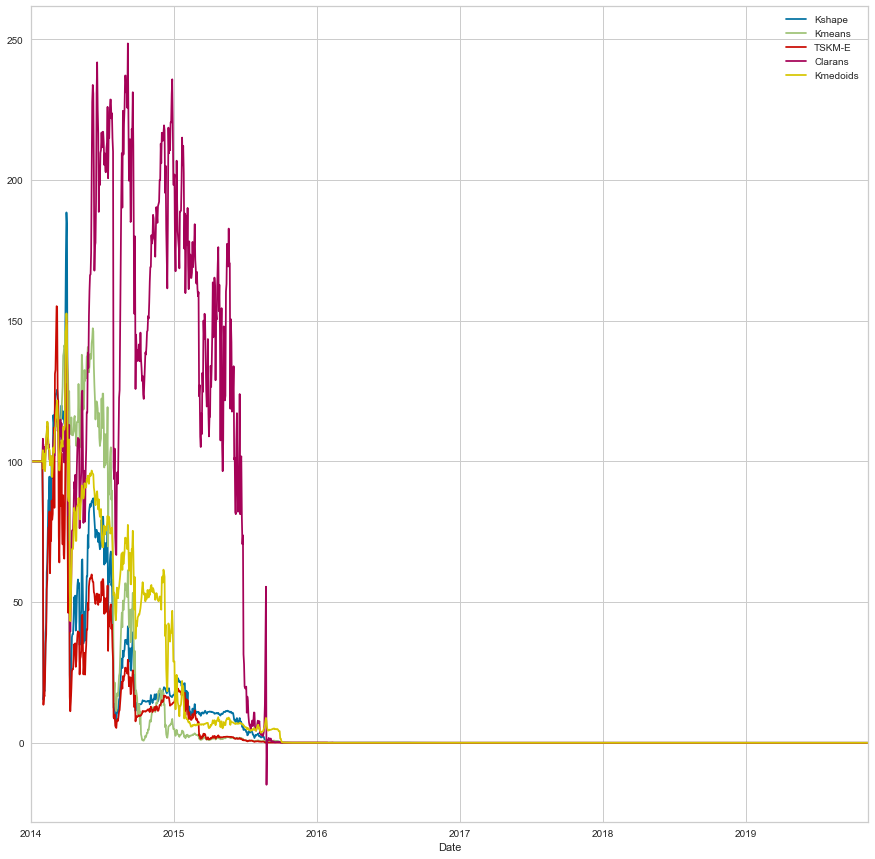

In [36]:
Clustering_Returns.plot(figsize=(15,15))

In [85]:
df = Estrategias.copy()

In [95]:
df = df.tail(20)
df

,LA1,SA1,LSA1,LA101,SA101,LSA101,LA2,SA2,LSA2,LA3,...,LSA53,LA54,SA54,LSA54,LA6,SA6,LSA6,LAMAR,SAMAR,LSAMAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-14,-0.007813,0.006089,-0.001725,-0.006475,0.007427,0.000951,-0.000182,0.013720,0.013538,-0.009409,...,-0.000951,-0.007427,0.006475,-0.000951,-0.009294,0.004608,-0.004686,-0.012435,0.001467,-0.010968
2019-10-15,0.030780,-0.026441,0.004339,0.033726,-0.023494,0.010232,0.038365,-0.018856,0.019508,0.034166,...,-0.010232,0.023494,-0.033726,-0.010232,0.031924,-0.025297,0.006626,0.012370,-0.044850,-0.032480
2019-10-16,0.003274,0.021103,0.024376,-0.003114,0.014715,0.011601,-0.019205,-0.001376,-0.020581,-0.006522,...,-0.011601,-0.014715,0.003114,-0.011601,0.004487,0.022317,0.026804,0.000402,0.018232,0.018634
2019-10-17,0.019587,-0.001976,0.017612,0.012724,-0.008839,0.003884,0.002075,-0.019488,-0.017413,0.012904,...,-0.003884,0.008839,-0.012724,-0.003884,0.017472,-0.004091,0.013381,0.007815,-0.013748,-0.005932
2019-10-18,-0.012285,0.008968,-0.003317,-0.013199,0.008055,-0.005144,-0.014222,0.007032,-0.007190,-0.018541,...,0.005144,-0.008055,0.013199,0.005144,-0.010966,0.010288,-0.000678,-0.006218,0.015036,0.008818
2019-10-21,0.011682,-0.046352,-0.034670,0.016448,-0.041586,-0.025138,0.045955,-0.012079,0.033877,0.019526,...,0.025138,0.041586,-0.016448,0.025138,0.012305,-0.045729,-0.033423,0.021447,-0.036587,-0.015141
2019-10-22,0.004022,-0.000875,0.003148,-0.017274,-0.022171,-0.039445,-0.009684,-0.014581,-0.024265,0.000825,...,0.039445,0.022171,0.017274,0.039445,0.007902,0.003005,0.010907,-0.015245,-0.020143,-0.035388
2019-10-23,0.006063,-0.017435,-0.011372,0.007057,-0.016441,-0.009384,0.008812,-0.014687,-0.005875,0.010967,...,0.009384,0.016441,-0.007057,0.009384,0.005512,-0.017987,-0.012475,0.004897,-0.018602,-0.013705
2019-10-24,-0.000739,-0.012380,-0.013119,0.012442,0.000801,0.013243,0.008486,-0.003155,0.005331,0.014320,...,-0.013243,-0.000801,-0.012442,-0.013243,-0.000763,-0.012403,-0.013166,0.020918,0.009277,0.030195


In [96]:
X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)[:,:,0]
ks = KShape(n_clusters=K, max_iter=100, n_init=100, verbose=0).fit(X)

In [101]:
X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)[:,:,0]
ks = KShape(n_clusters=K, max_iter=100, n_init=100, verbose=0).fit(X)

index = list(range(len(df.columns)))
columns = ['strategies', 'clusters', 'selection']
results = pd.DataFrame(index=index, columns=columns)
results['clusters'] = ks.labels_
results['strategies'] = df.columns

sharpeclusters = []
dfaux = df.tail(n)
for i in range(results['clusters'].nunique()):
    l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
    dfexp = dfaux.pct_change().iloc[:, l].sum(axis=1, skipna=True)

    sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
sharpeclusters = np.asanyarray(sharpeclusters)

selection = sharpeclusters.argmax()
cond = results['clusters'] == selection

results['selection'] = np.where(cond, 1, 0)

results['strategies'][results['selection'] == 1].values.tolist()

['SA1', 'LSA1', 'SA101', 'LA2', 'LSA2', 'LSA44', 'SAMAR', 'LSAMAR']

In [ ]:
X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(df.T.values)[:,:,0]

ks = KShape(n_clusters=K, max_iter=100, n_init=100, verbose=0).fit(X)

index = list(range(len(df.columns)))
columns = ['strategies', 'clusters', 'selection']

results = pd.DataFrame(index=index, columns=columns)

results['clusters'] = ks.labels_
results['strategies'] = df.columns

sharpeclusters = []
dfaux = df.tail(n)
for i in range(results['clusters'].nunique()):
    l = results.loc[results['clusters'] == i].index.values.astype(int).tolist()
    dfexp = dfaux.pct_change().iloc[:, l].sum(axis=1, skipna=True)

    sharpeclusters.append(pf.timeseries.perf_stats(dfexp)['Sharpe ratio'])
sharpeclusters = np.asanyarray(sharpeclusters)

selection = sharpeclusters.argmax()
cond = results['clusters'] == selection

results['selection'] = np.where(cond, 1, 0)

return results['strategies'][results['selection'] == 1].values.tolist()